# Global Stock Market Analytics

in this project we will look at predicting the open direction of the Nifty 50 
index by looking at other indices and indicators. We will break the project up 
into five phases:

1. preparing the master data from the global indices
2. preliminary analysis of data
3. predictive modelling of open direction of Nifty 50
4. comparing different models at prediction
5. sentiment analysis of X / Twitter data relating to Nifty 50


## Phase 1 - Prepare the Master Data

We begin by preparing the data that we will be working with. We import the libraries we will 
be using, set some plotting configurations, and declare some constants. The indexes of interest are:

 - NSEI:  Nifty 50
 - DJI:   Dow Jones Index
 - IXIC:  Nasdaq
 - HSI:   Hang Seng
 - N225:  Nikkei 225
 - GDAXI: Dax
 - VIX:   Volatility Index

In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import yfinance as yf
import ta

import nltk

from scipy import stats

from statsmodels.api import Logit
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.metrics import classification_report, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import torch
import torch.nn as nn
import torch.utils.data as utils

from string import punctuation, digits

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from wordcloud import WordCloud



plt.style.use("ggplot")
sns.set_style("darkgrid")
sns.set_context("paper")


INDICES  = ['NSEI', 'DJI', 'IXIC', 'HSI', 'N225', 'GDAXI', 'VIX']
COLUMNS  = [f"{index}_DAILY_RETURNS" for index in INDICES]

Next, we declare a function that we will use to download the OHLC data, and make use of it:

In [377]:

def retrieve_data(index, start_date = '2017-12-1', end_date = '2024-1-31', progress = False):
    data = yf.download(f'^{index}', start_date, end_date, progress = progress)

    # create daily returns for each index
    data['Daily Returns'] = data.Close.pct_change() * 100

    # rename columns - prefix with index name
    data.columns = ["_".join(c.upper() for c in column.split()) for column in data.columns]
    data.columns = [f"{index}_{column}" for column in data.columns]

    return data


data = [retrieve_data(index) for index in INDICES]

Next, we declare a function we will use to test the normality of the data we will be working with:

In [378]:
def test_normality(data, column_name, index_name):
    print()
    print(f"\t Index {index_name}")
    print(f"\tColumn {column_name}")
    print()

    data = data[column_name].dropna()

    if data.shape[0] < 50:
        print("\t     Shapiro-Wilks Test:")
        result = stats.shapiro(data)
    else:
        print("\tKolmogorov-Smirnov Test:")
        result = sm.stats.diagnostic.lilliefors(data)

    print(f"\t                p-value: {result[1]}")

    if result[1] < 0.05:
        print("\treject null hypothesis - data is not drawn from a normal distribution")
    else:
        print("\tfail to reject null hypothesis - data is drawn from a normal distribution")

    print()


for d, c, i in zip(data, COLUMNS, INDICES):
    test_normality(d, c, i)


	 Index NSEI
	Column NSEI_DAILY_RETURNS

	Kolmogorov-Smirnov Test:
	                p-value: 0.0009999999999998899
	reject null hypothesis - data is not drawn from a normal distribution


	 Index DJI
	Column DJI_DAILY_RETURNS

	Kolmogorov-Smirnov Test:
	                p-value: 0.0009999999999998899
	reject null hypothesis - data is not drawn from a normal distribution


	 Index IXIC
	Column IXIC_DAILY_RETURNS

	Kolmogorov-Smirnov Test:
	                p-value: 0.0009999999999998899
	reject null hypothesis - data is not drawn from a normal distribution


	 Index HSI
	Column HSI_DAILY_RETURNS

	Kolmogorov-Smirnov Test:
	                p-value: 0.0009999999999998899
	reject null hypothesis - data is not drawn from a normal distribution


	 Index N225
	Column N225_DAILY_RETURNS

	Kolmogorov-Smirnov Test:
	                p-value: 0.0009999999999998899
	reject null hypothesis - data is not drawn from a normal distribution


	 Index GDAXI
	Column GDAXI_DAILY_RETURNS

	Kolmogorov-Smirnov 

Next, we declare a function we will use to create qq-plots of the data we will be working with:

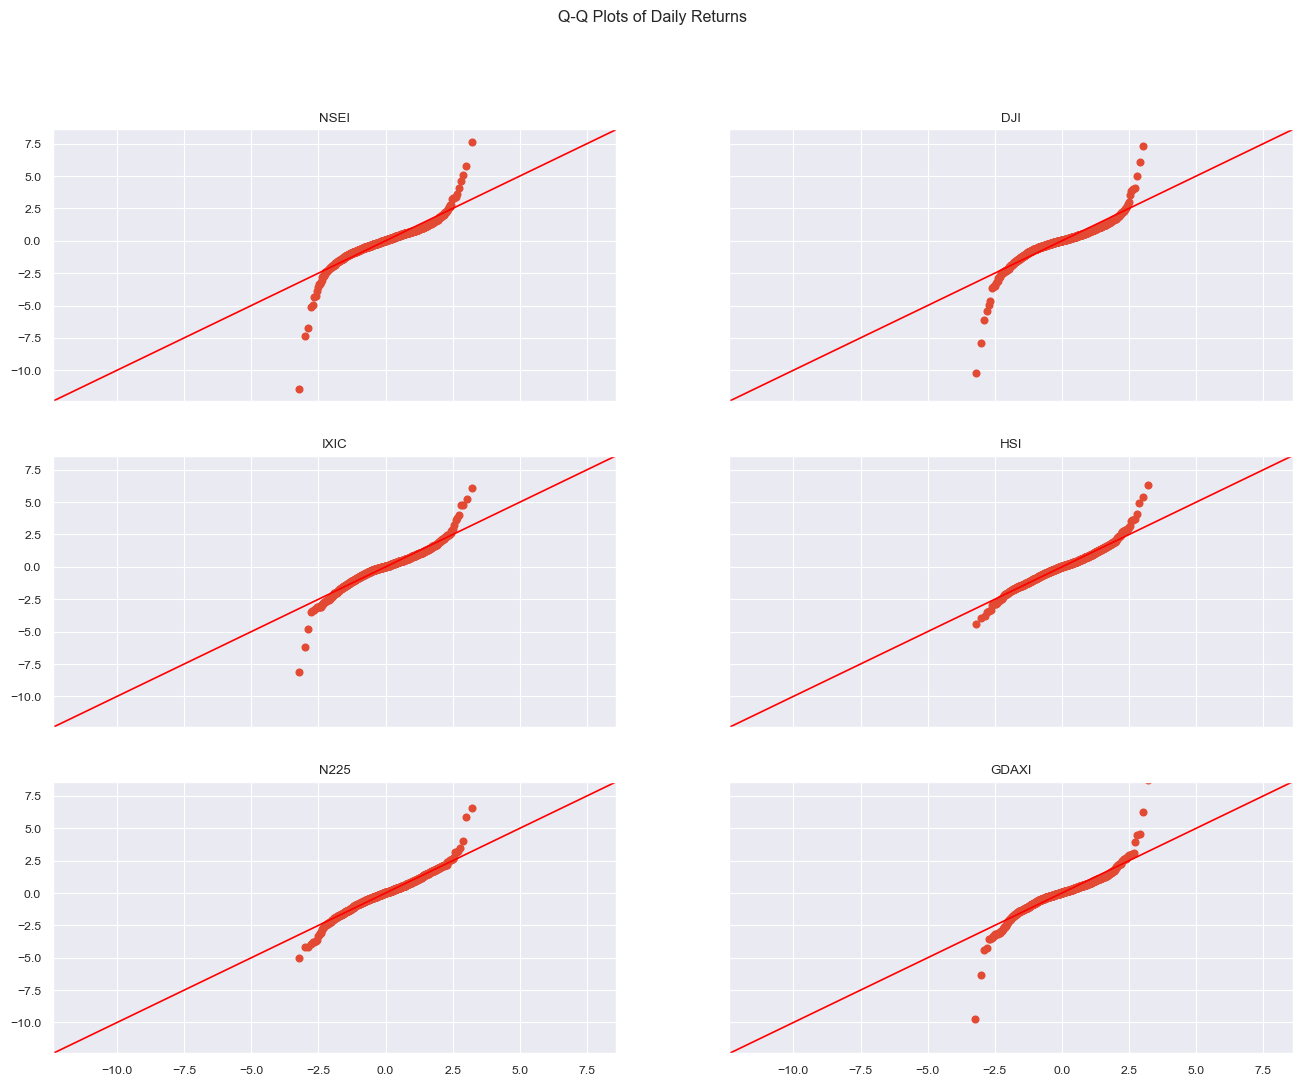

In [379]:
#| label: q-q-plots-daily-returns

def qq_plots(data, title, count = 6):
    fig, axes = plt.subplots(3, 2, figsize = (16, 12), sharex = True, sharey = True)
    fig.suptitle(title)

    for index in range(count):
        axes[index // 2, index % 2].set_title(INDICES[index])
        sm.graphics.qqplot(data[index][COLUMNS[index]].dropna(), line = "45", fit = True, ax = axes[index // 2, index % 2])
        axes[index // 2, index % 2].set_xlabel("")
        axes[index // 2, index % 2].set_ylabel("")


qq_plots(data, "Q-Q Plots of Daily Returns")

The daily returns do not appear to follow - or be drawn from - a Normal Distribution - specifically at the tails.

Next, we declare a function we will use to merge the data, using LOCF for missing data, and adding variables for MONTH, QUARTER, and YEAR:

In [380]:
def merge_data(data, start_date = '2018-01-02', end_date = '2023-12-29'):
    # merge data with outer join
    merged = pd.concat(data, axis = 1)

    # impute missing data using LOCF (forward fill)
    merged.ffill(inplace = True)

    # add indicators for MONTH, QUARTER, and YEAR
    merged['MONTH']   = merged.index.month
    merged['QUARTER'] = merged.index.quarter
    merged['YEAR']    = merged.index.year

    return merged[start_date:end_date]


master = merge_data(data)

## Phase 2 - Preliminary Analysis

Now that we have our master data we perform some preliminary analysis hoping to answer the following questions:

1. Which index has given consistently good returns?
2. Which index was highly volatile?
3. How are global markets correlated during 6 years period and is the correlation structure similar in the recent year-2023?
4. Assuming primary target variable as “Nifty Opening Price Direction”, what are preliminary insights?

Lets define a few functions we will use across our analysis - to begin with, a function that plots box plots of the daily returns by year:

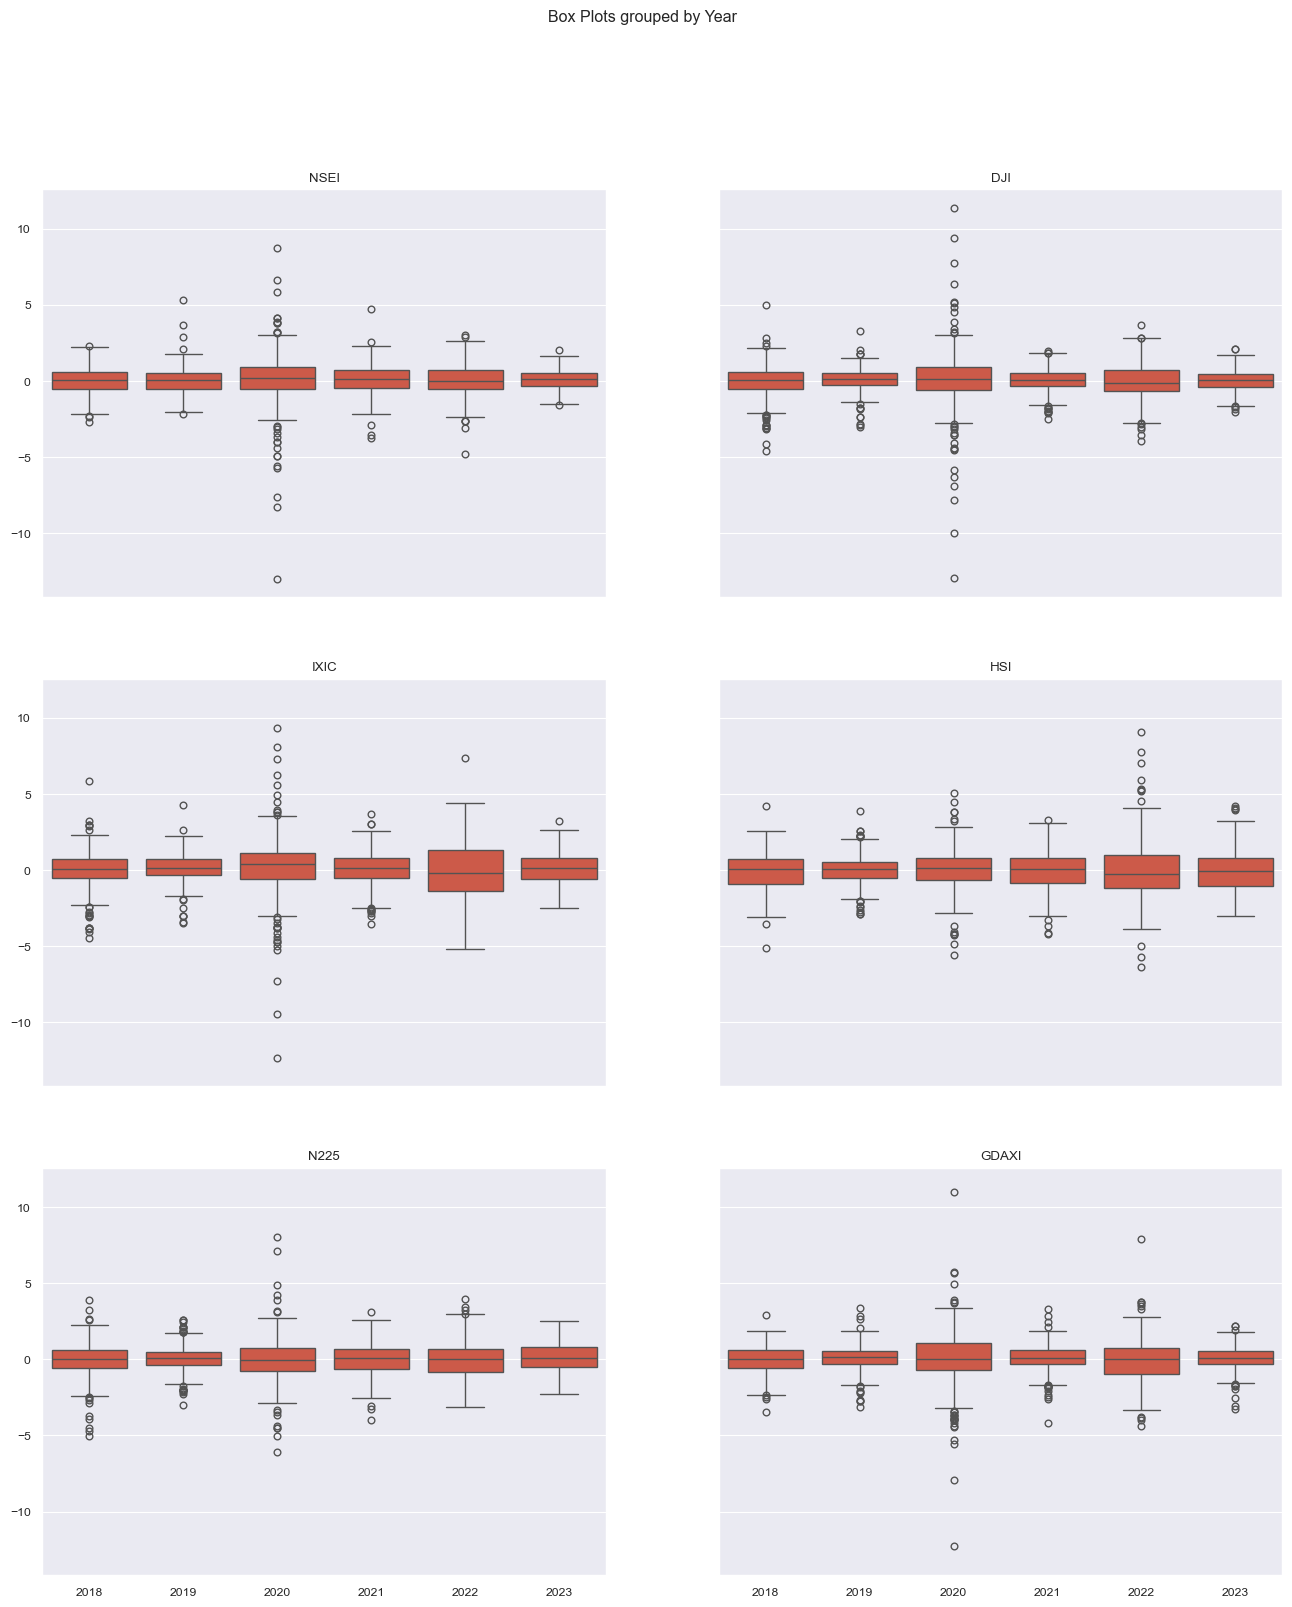

In [381]:
#| label: box-plots-daily-returns-yearly

def performance_analytics_box_plots(data, group_by, title, count = 6):
    fig, axes = plt.subplots(3, 2, figsize = (16, 18), sharex = True, sharey = True)
    fig.suptitle(title)

    for index in range(count):
        axes[index // 2, index % 2].set_title(INDICES[index])
        sns.boxplot(x = data[group_by], y = data[COLUMNS[index]], ax = axes[index // 2, index % 2])
        axes[index // 2, index % 2].set_xlabel("")
        axes[index // 2, index % 2].set_ylabel("")


performance_analytics_box_plots(master, "YEAR", "Box Plots grouped by Year")

All indexes seem pretty consistent - all years have similar spreads, and consistent medians, with one or two 
exceptions. All indexes for 2020 have more outliers than normal. But HSI seems to have more outliers in 2022 
than in 2020.

Next, we declare a function that prints a table of summary statistics for the daily returns of each index:

In [382]:
def performance_analytics_tables(data, group_by, count = 6):
    for index in range(count):
        table = round(data.groupby(group_by, observed = False)[COLUMNS[index]].agg(['count', 'mean', 'std', 'var']), 3)
        print(f"\n{INDICES[index]}\n\n{table}\n\n")


performance_analytics_tables(master, "YEAR")


NSEI

      count   mean    std    var
YEAR                            
2018    260  0.012  0.804  0.647
2019    260  0.062  0.862  0.744
2020    262  0.059  2.004  4.015
2021    261  0.094  0.980  0.960
2022    260  0.055  1.096  1.202
2023    260  0.079  0.620  0.384



DJI

      count   mean    std    var
YEAR                            
2018    260 -0.035  1.143  1.306
2019    260  0.099  0.784  0.614
2020    262  0.057  2.277  5.186
2021    261  0.075  0.773  0.597
2022    260 -0.025  1.237  1.531
2023    260  0.060  0.709  0.503



IXIC

      count   mean    std    var
YEAR                            
2018    260 -0.020  1.330  1.768
2019    260  0.133  0.975  0.950
2020    262  0.170  2.200  4.838
2021    261  0.096  1.124  1.262
2022    260 -0.124  2.000  4.001
2023    260  0.157  1.085  1.177



HSI

      count   mean    std    var
YEAR                            
2018    260 -0.035  1.244  1.547
2019    260  0.033  0.981  0.962
2020    262  0.026  1.445  2.087
2021    261

The clear winner here is NSEI - not one year in the range has a negative mean return. And with the 
exception of 2020 and 2022, NSEI has low volatility (< 1) throughout all years.

Next, we declare a function that plots median daily returns by year:

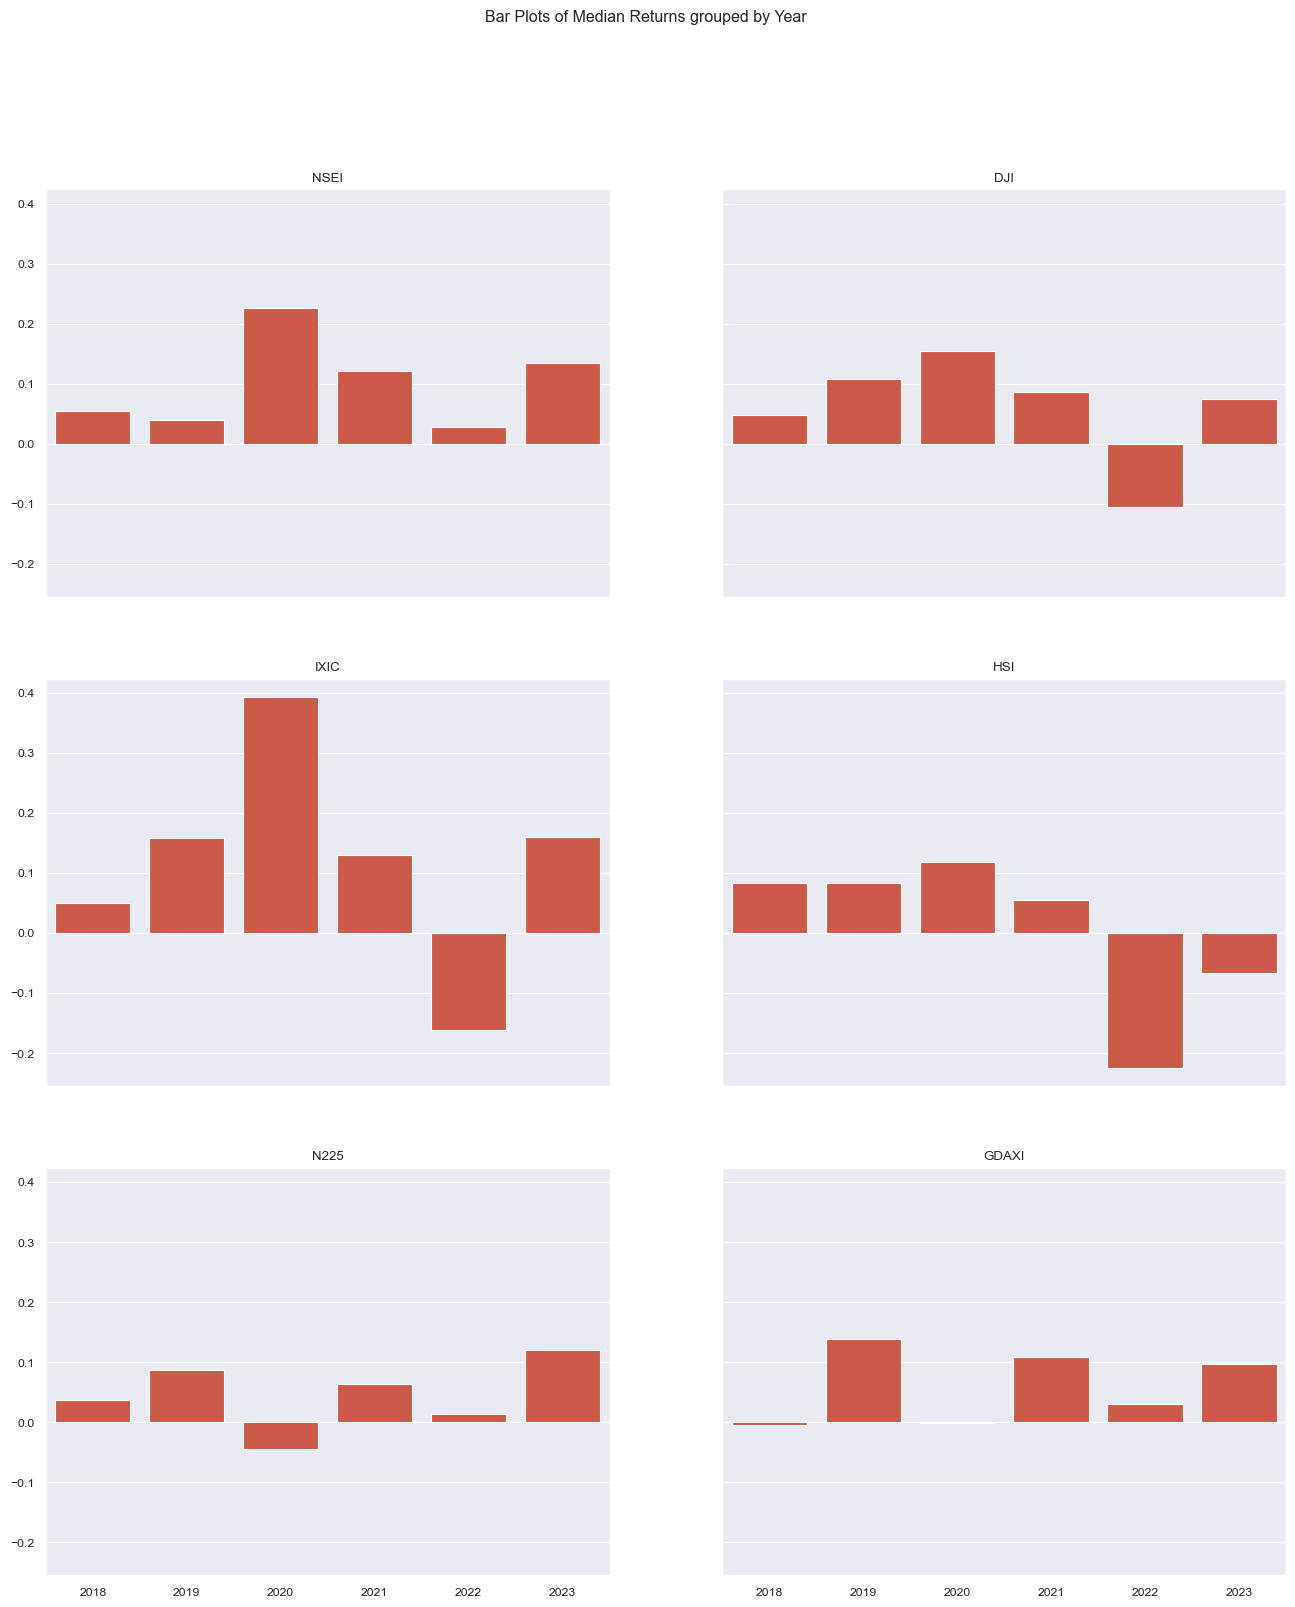

In [383]:
#| label: bar-plots-daily-returns-yearly

def performance_analytics_bar_plots(data, group_by, title, count = 6, aggfunc = "median"):
    fig, axes = plt.subplots(3, 2, figsize = (16, 18), sharex = True, sharey = True)
    fig.suptitle(title)

    for index in range(count):
        axes[index // 2, index % 2].set_title(INDICES[index])
        table = data.groupby(group_by, observed = False)[COLUMNS[index]].agg([aggfunc])
        sns.barplot(x = table.index, y = table[aggfunc], ax = axes[index // 2, index % 2])
        axes[index // 2, index % 2].set_xlabel("")
        axes[index // 2, index % 2].set_ylabel("")

performance_analytics_bar_plots(master, "YEAR", "Bar Plots of Median Returns grouped by Year")

The clear winner here is NSEI - at no time is the median daily returns for any of the years below 0. 
IXIC has an unusually high 2020, but a bad 2022. HSI also has an unusually bad 2022.

Next, we plot of heatmaps by year and quarter showing mean returns:

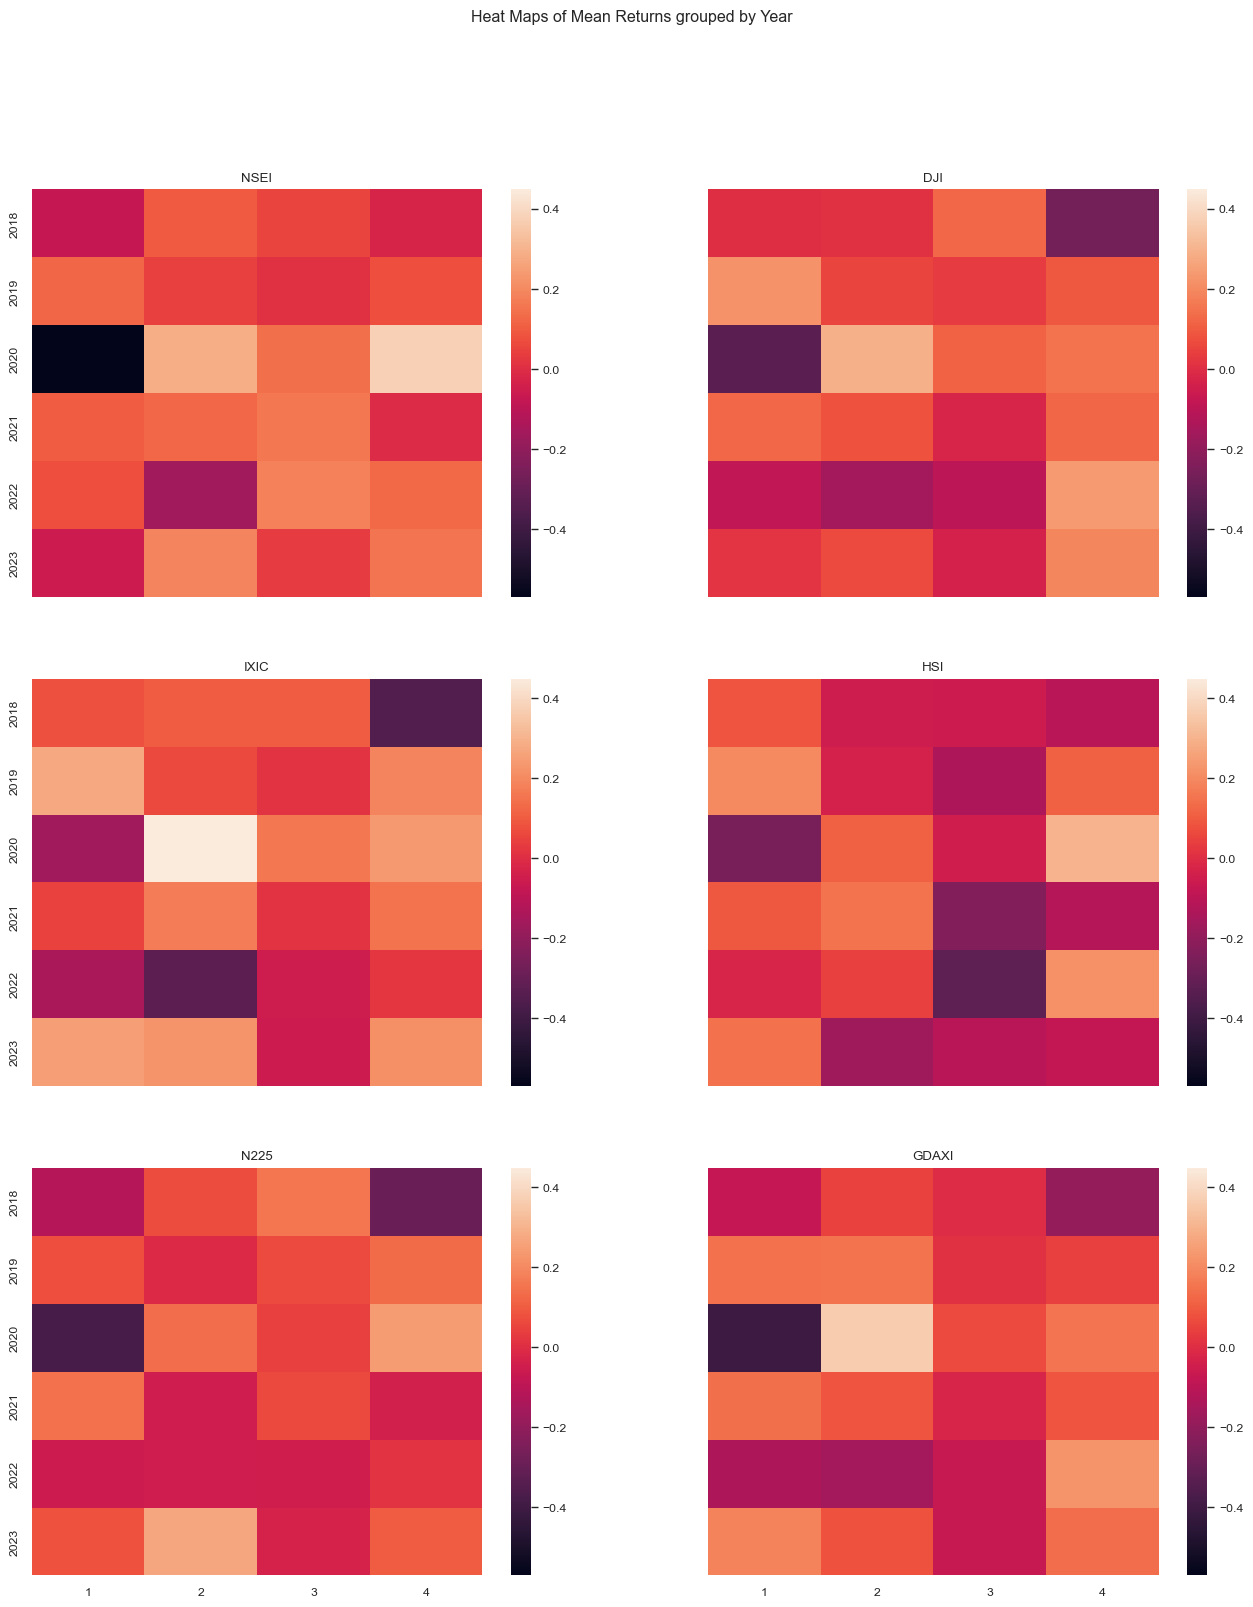

In [384]:
#| label: heat-maps-mean-daily-returns-yearly

def performance_analytics_heat_maps(data, group_by, title, column = "QUARTER", count = 6, aggfunc = "median"):
    fig, axes = plt.subplots(3, 2, figsize = (16, 18), sharex = True, sharey = True)
    fig.suptitle(title)

    tables = []
    values = []
    for index in range(count):
        table = pd.pivot_table(data, values = COLUMNS[index], index = [group_by], columns = [column], aggfunc = aggfunc, observed = False)
        tables.append(table)
        values.extend(table.values.ravel())

    vmax = max(values)
    vmin = min(values)

    for index in range(count):
        axes[index // 2, index % 2].set_title(INDICES[index])
        sns.heatmap(tables[index], ax = axes[index // 2, index % 2], vmin = vmin, vmax = vmax)
        axes[index // 2, index % 2].set_xlabel("")
        axes[index // 2, index % 2].set_ylabel("")

performance_analytics_heat_maps(master, "YEAR", "Heat Maps of Mean Returns grouped by Year", aggfunc = "mean")

With the exception of the 1st quarter in 2020, NSEI has pretty consistent daily returns - where most cells 
sre pretty bright, denoting above 0. Most of the other indexes have a blend of light and dark, which would 
indicate more volatile behaviour over the quarters.

Next we look at heatmaps by year and quarter showing median returns:

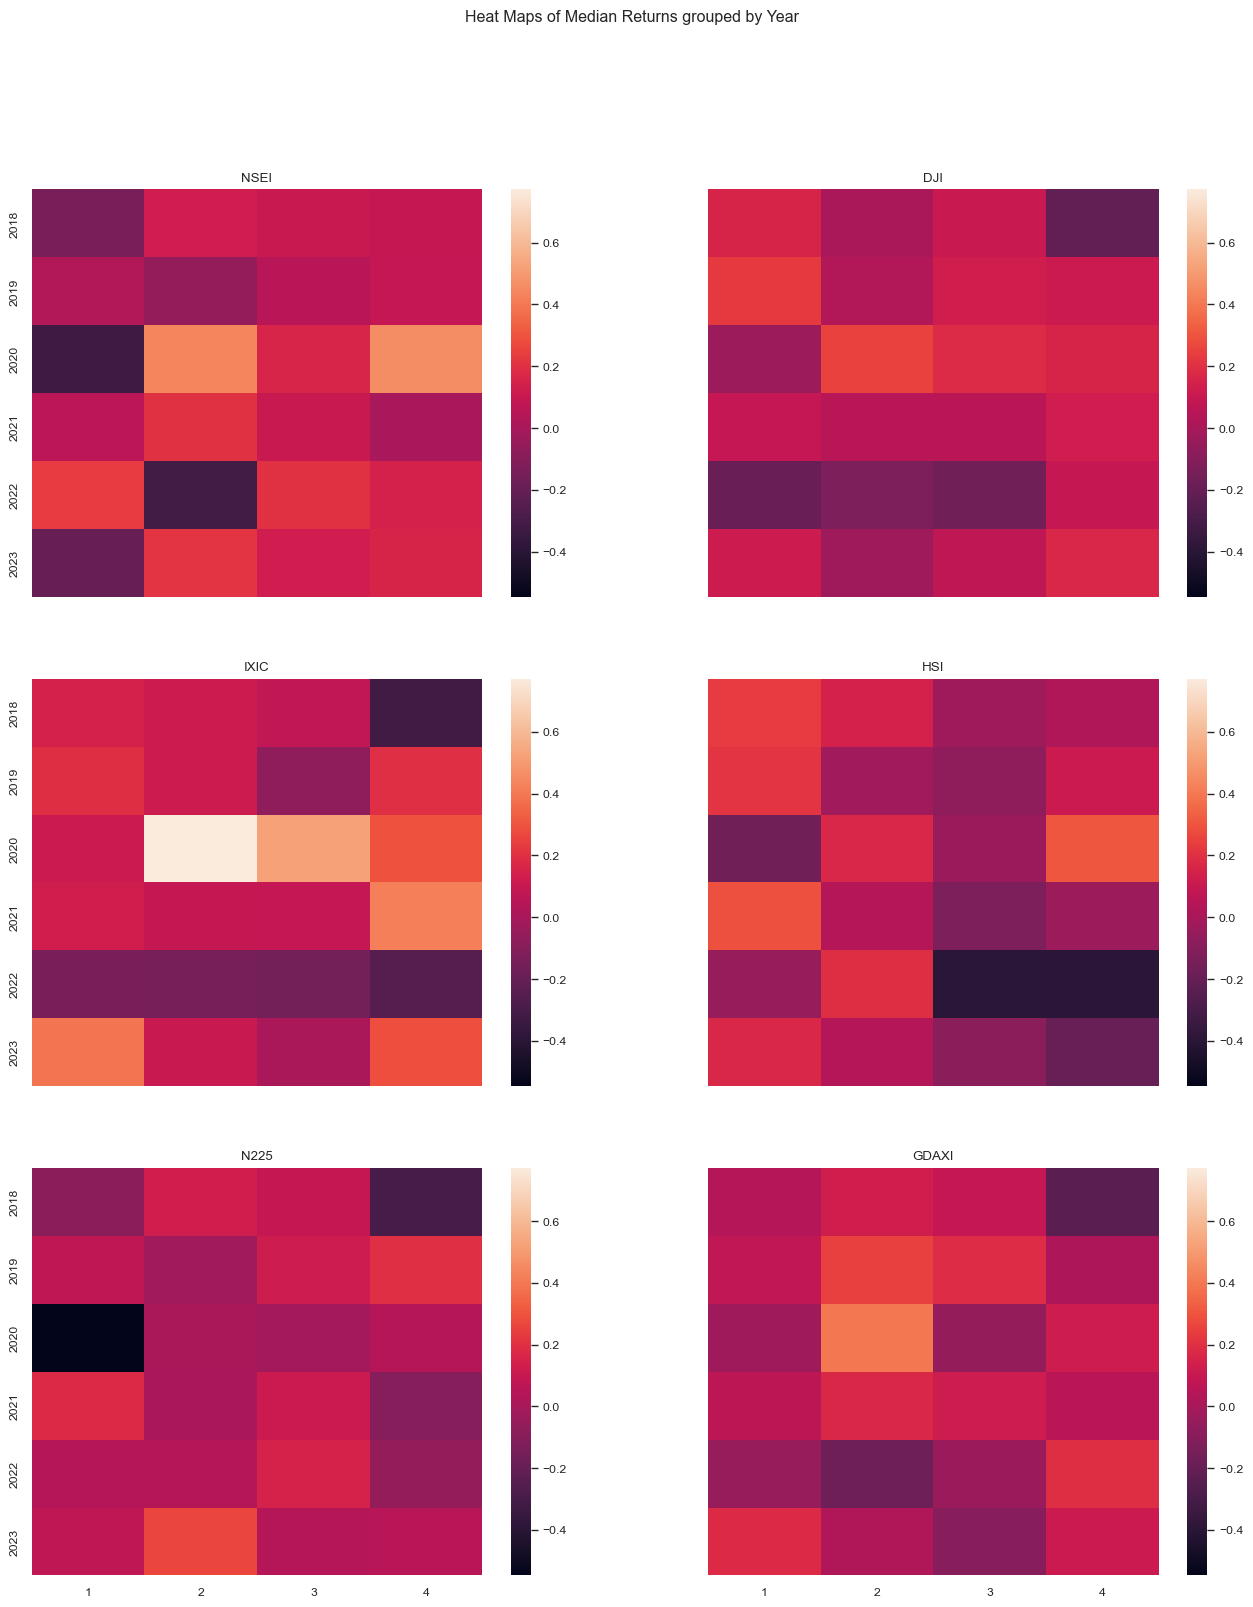

In [385]:
#| label: heat-maps-median-daily-returns-yearly

performance_analytics_heat_maps(master, "YEAR", "Heat Maps of Median Returns grouped by Year")

On the other hand, when looking at median returns across quarters NSEI seems pretty average - there does not seem to be a clear winner here.

Lets look at a correlation matrix of the 6 years daily returns:

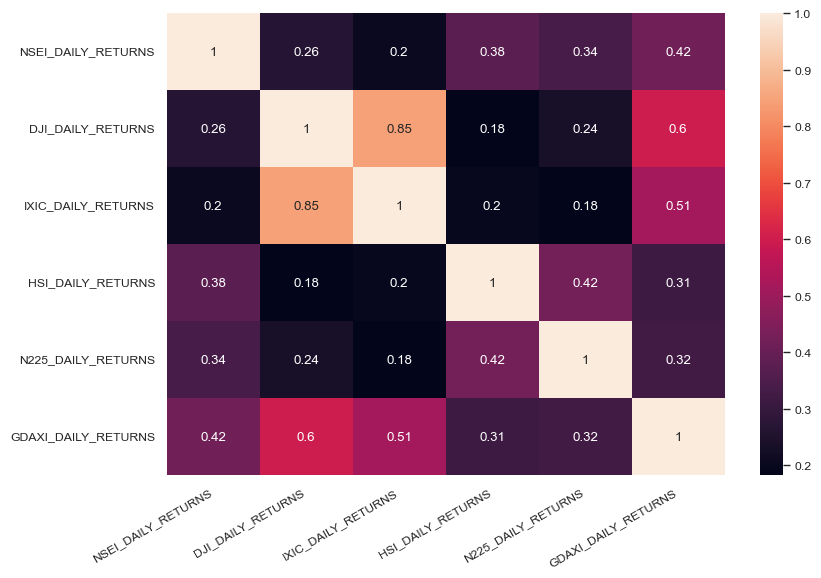

In [386]:
#| label: correlation-matrix-daily-returns-all-years

def correlation_matrix(data):
    plt.figure(figsize = (9, 6))
    matrix = data[COLUMNS[:-1]].corr()

    ax = sns.heatmap(matrix, annot = True)
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation = 30,
        horizontalalignment = "right"
    )


correlation_matrix(master)

It looks like strong correlation between daily returns of IXIC and DJI, and some correlation between GDAXI and 
DJI. These indexes are likely to result in multicolinearity at the regression stage.

Next, we look at the same correlation matrix for the 2023 year alone to see if there are similar correlations:

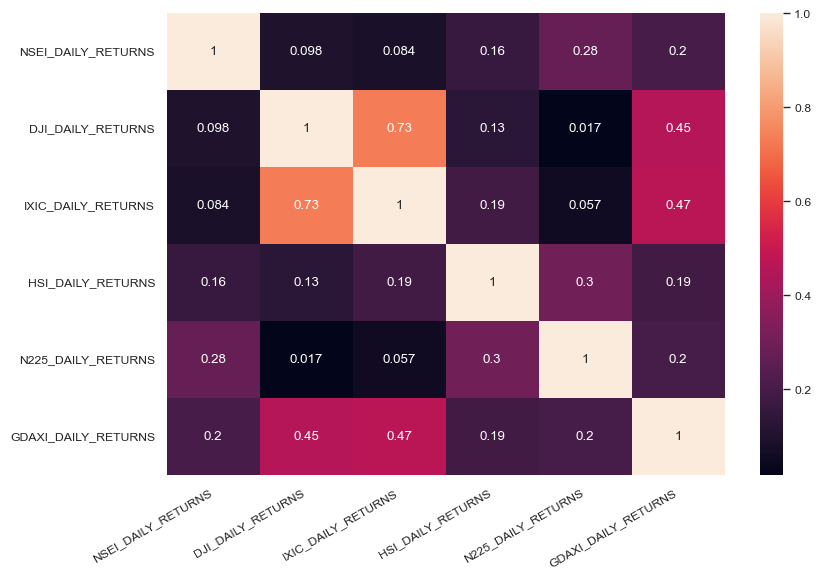

In [387]:
#| label: correlation-matrix-daily-returns-last-year

correlation_matrix(master['2023-01-02':'2023-12-29'])

We can see similar - but slightly weaker - correlations exist between the same indexes for 2023.

Next, we do similar analysis for the Pandemic period - Pre Covid, Covid, and Post Covid:

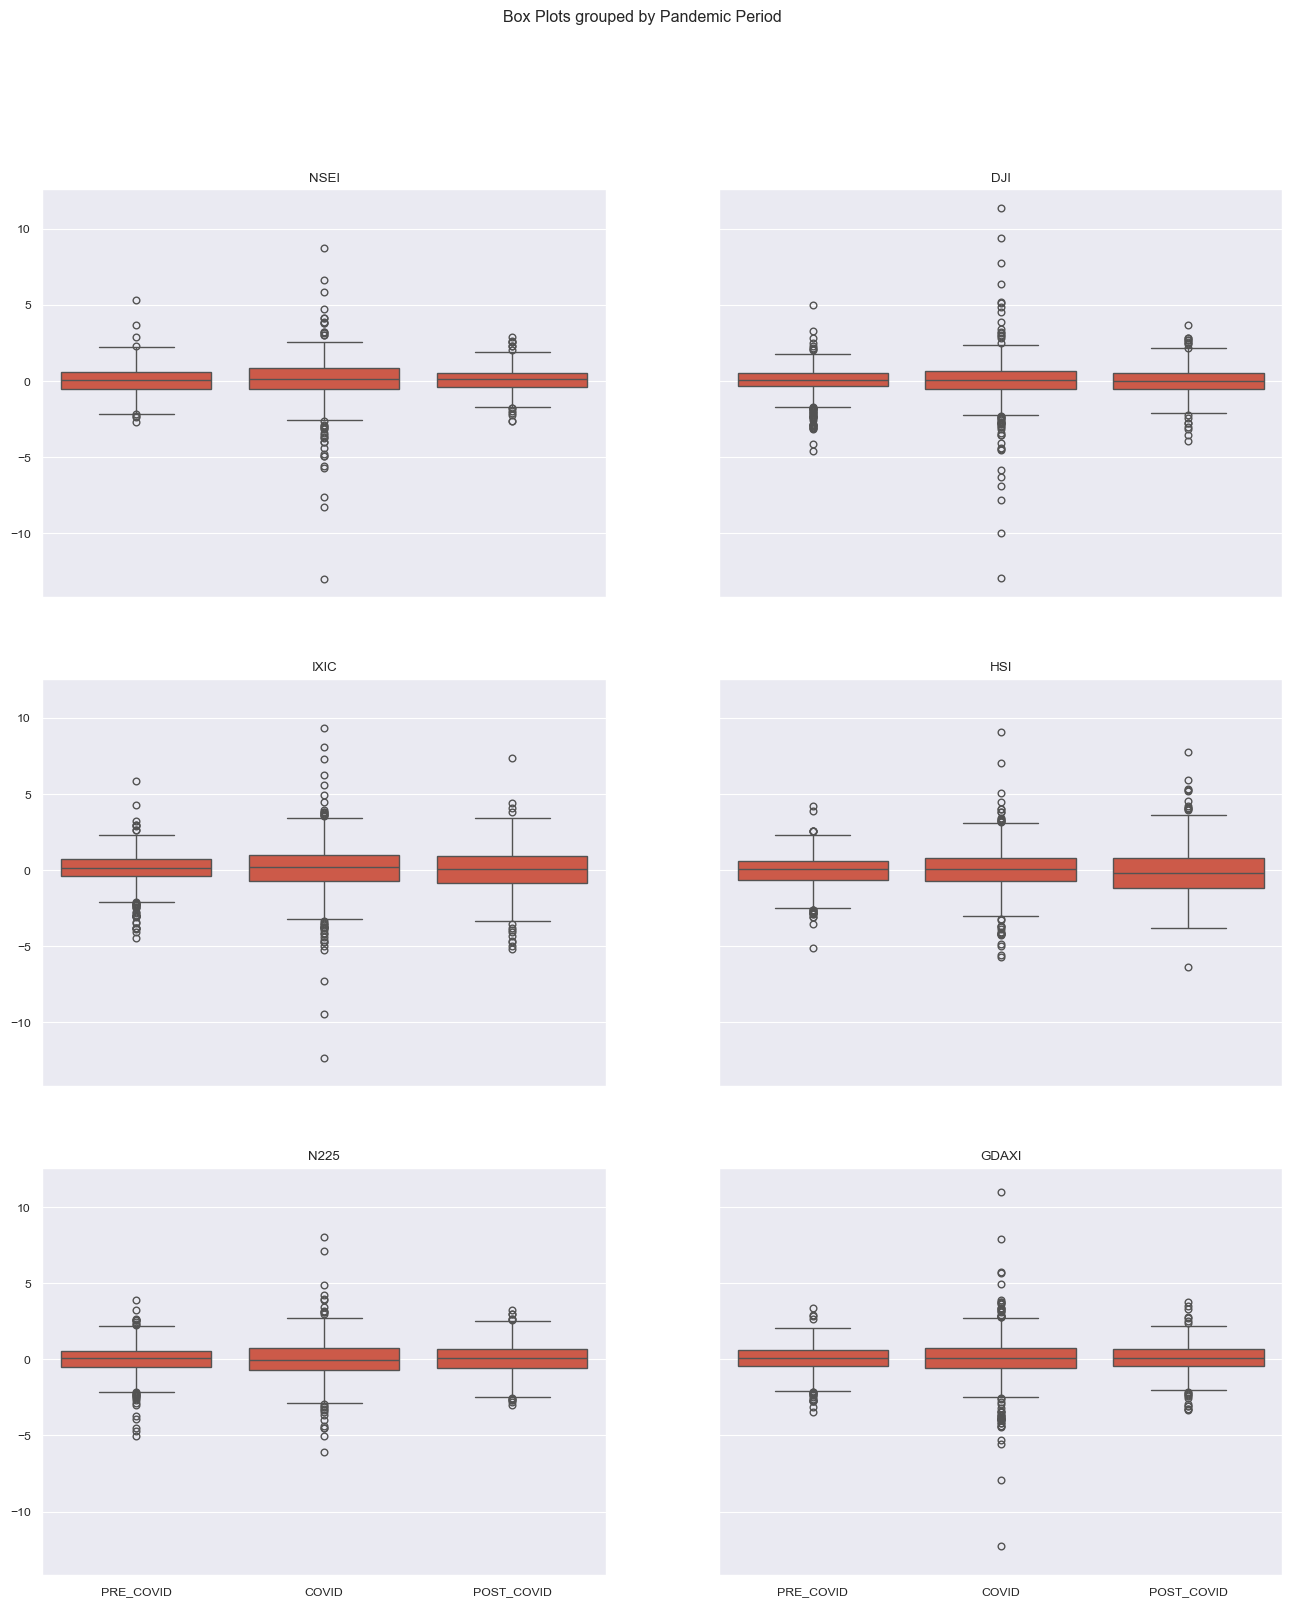

In [388]:
#| label: box-plots-daily-returns-covid

CONDITIONS = [(master.index <= '2020-01-30'), ('2022-05-05' <= master.index)]
CHOICES    = ['PRE_COVID', 'POST_COVID']

master['PANDEMIC'] = np.select(CONDITIONS, CHOICES, 'COVID')
master['PANDEMIC'] = pd.Categorical(master['PANDEMIC'], categories = ['PRE_COVID', 'COVID', 'POST_COVID'], ordered = True)



performance_analytics_box_plots(master, "PANDEMIC", "Box Plots grouped by Pandemic Period")

We can see that the spreads of each index over the Pandemic are consistent, with the Covid period itself having 
more outliers - which of course you might expect.

Next we look at summary statistics for the Pandemic:

In [389]:
performance_analytics_tables(master, "PANDEMIC")


NSEI

            count   mean    std    var
PANDEMIC                              
PRE_COVID     542  0.033  0.830  0.690
COVID         589  0.069  1.563  2.442
POST_COVID    432  0.082  0.777  0.604



DJI

            count   mean    std    var
PANDEMIC                              
PRE_COVID     542  0.034  0.969  0.938
COVID         589  0.043  1.657  2.745
POST_COVID    432  0.038  0.981  0.962



IXIC

            count   mean    std    var
PANDEMIC                              
PRE_COVID     542  0.062  1.153  1.330
COVID         589  0.077  1.812  3.285
POST_COVID    432  0.065  1.525  2.326



HSI

            count   mean    std    var
PANDEMIC                              
PRE_COVID     542 -0.013  1.126  1.268
COVID         589  0.012  1.508  2.274
POST_COVID    432 -0.047  1.664  2.769



N225

            count   mean    std    var
PANDEMIC                              
PRE_COVID     542  0.000  1.046  1.095
COVID         589  0.017  1.417  2.009
POST_COVID    432  0.05

All indexes had higher volatility over the Covid period. 

- NSEI performed reasonably well over the Covid period, with an increase in volatility in the Covid period, and with a significant bump in the Post Covid period. 
- DJI seemed consisten over the three periods, with an increase in volatility in the Covid period.
- IXIC looked pretty good over the three period, but maybe slightly more volatile overall, and in particular in the Covid period. 
- HSI has performed poorely in general, with negative returns in the pre and post Covid periods, and with consistently greater volatility than most.
- N225 appears to perform not so well, and with relatively high volatility. 
- GDAXI also appears to perform not so well in general, and with relatively high volatility. 


Next, we we look at median daily returns by Pandemic period:

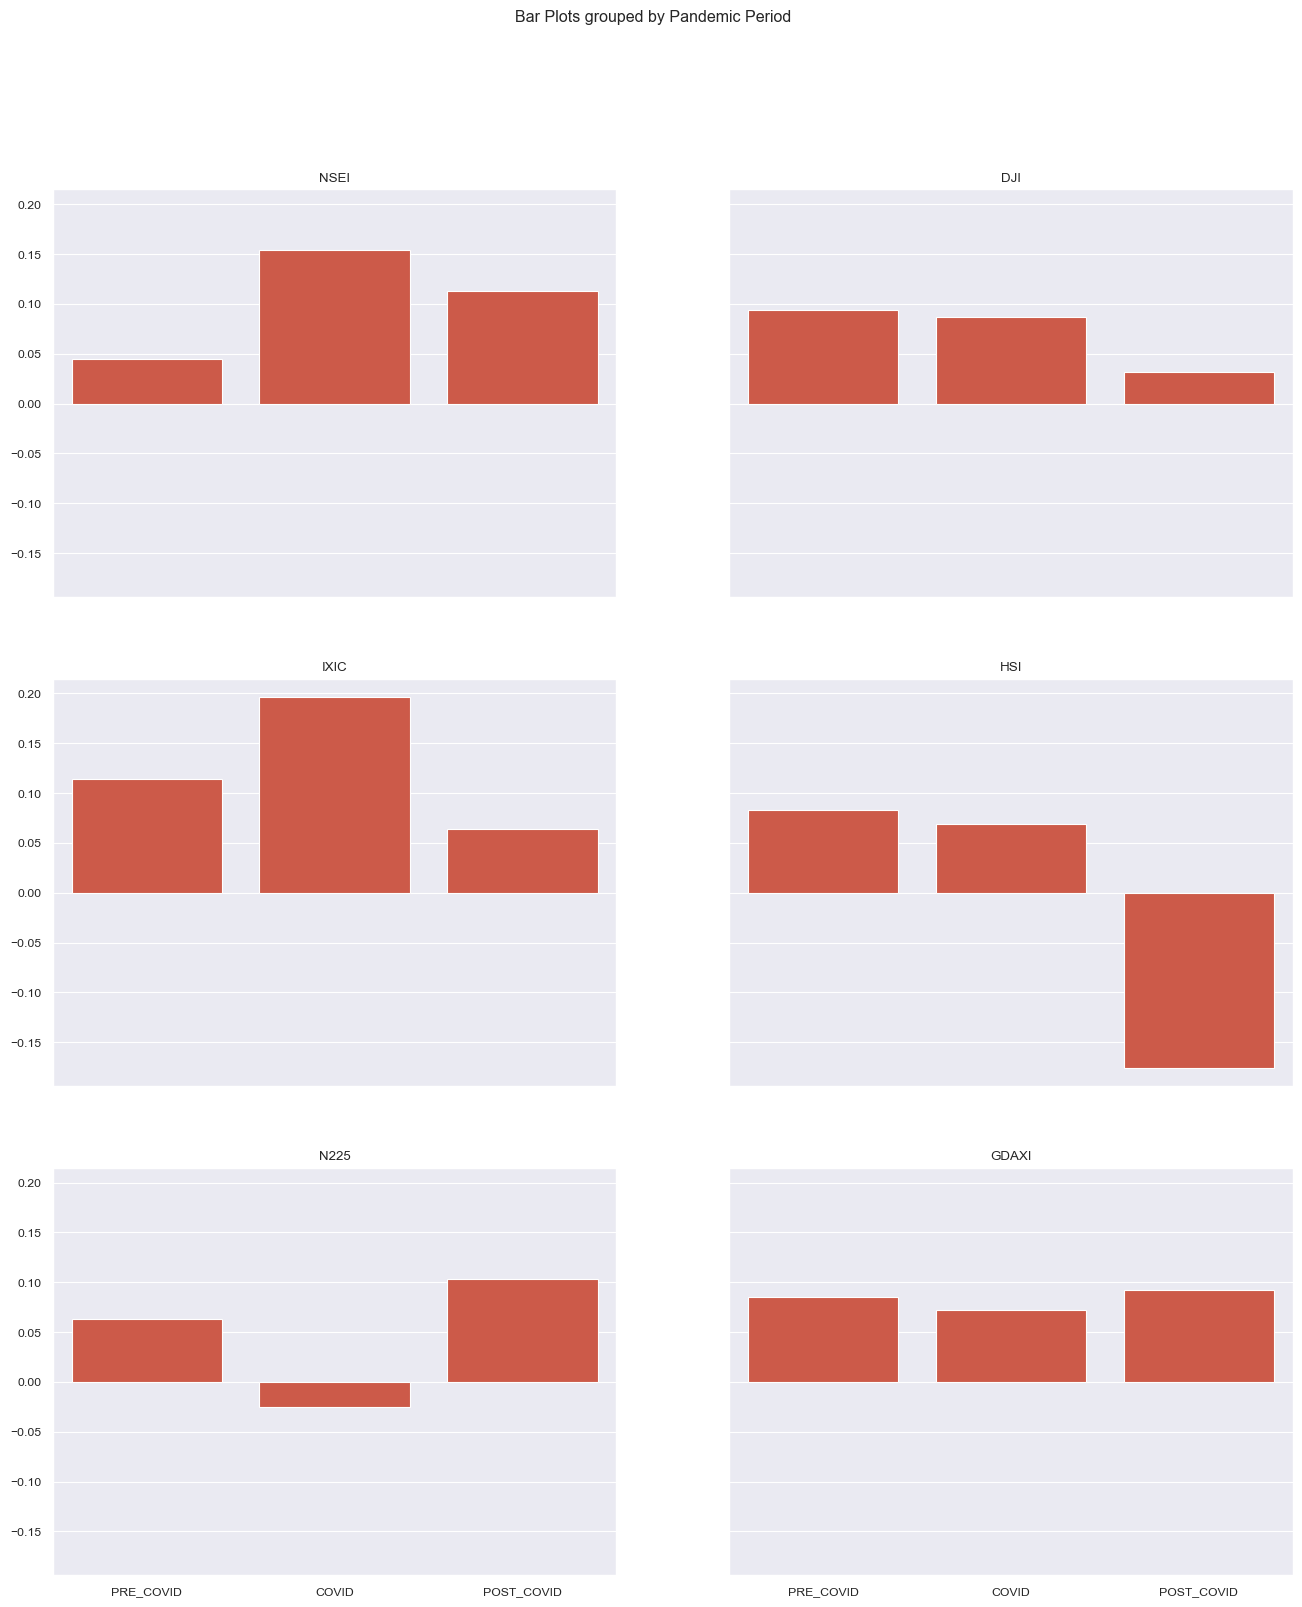

In [390]:
#| label: bar-plots-daily-returns-covid

performance_analytics_bar_plots(master, "PANDEMIC", "Bar Plots grouped by Pandemic Period")

We can see that IXIC looks like the clear winner here, with NSEI in second place, and DJI and GSAXI in a 
fight for third place. HSI appears to have had a terrible Post Covid period, and N225 appears to have had 
a pretty bad Covid period.

Next, we plot of heatmaps by Pandemic period and quarter showing mean returns:

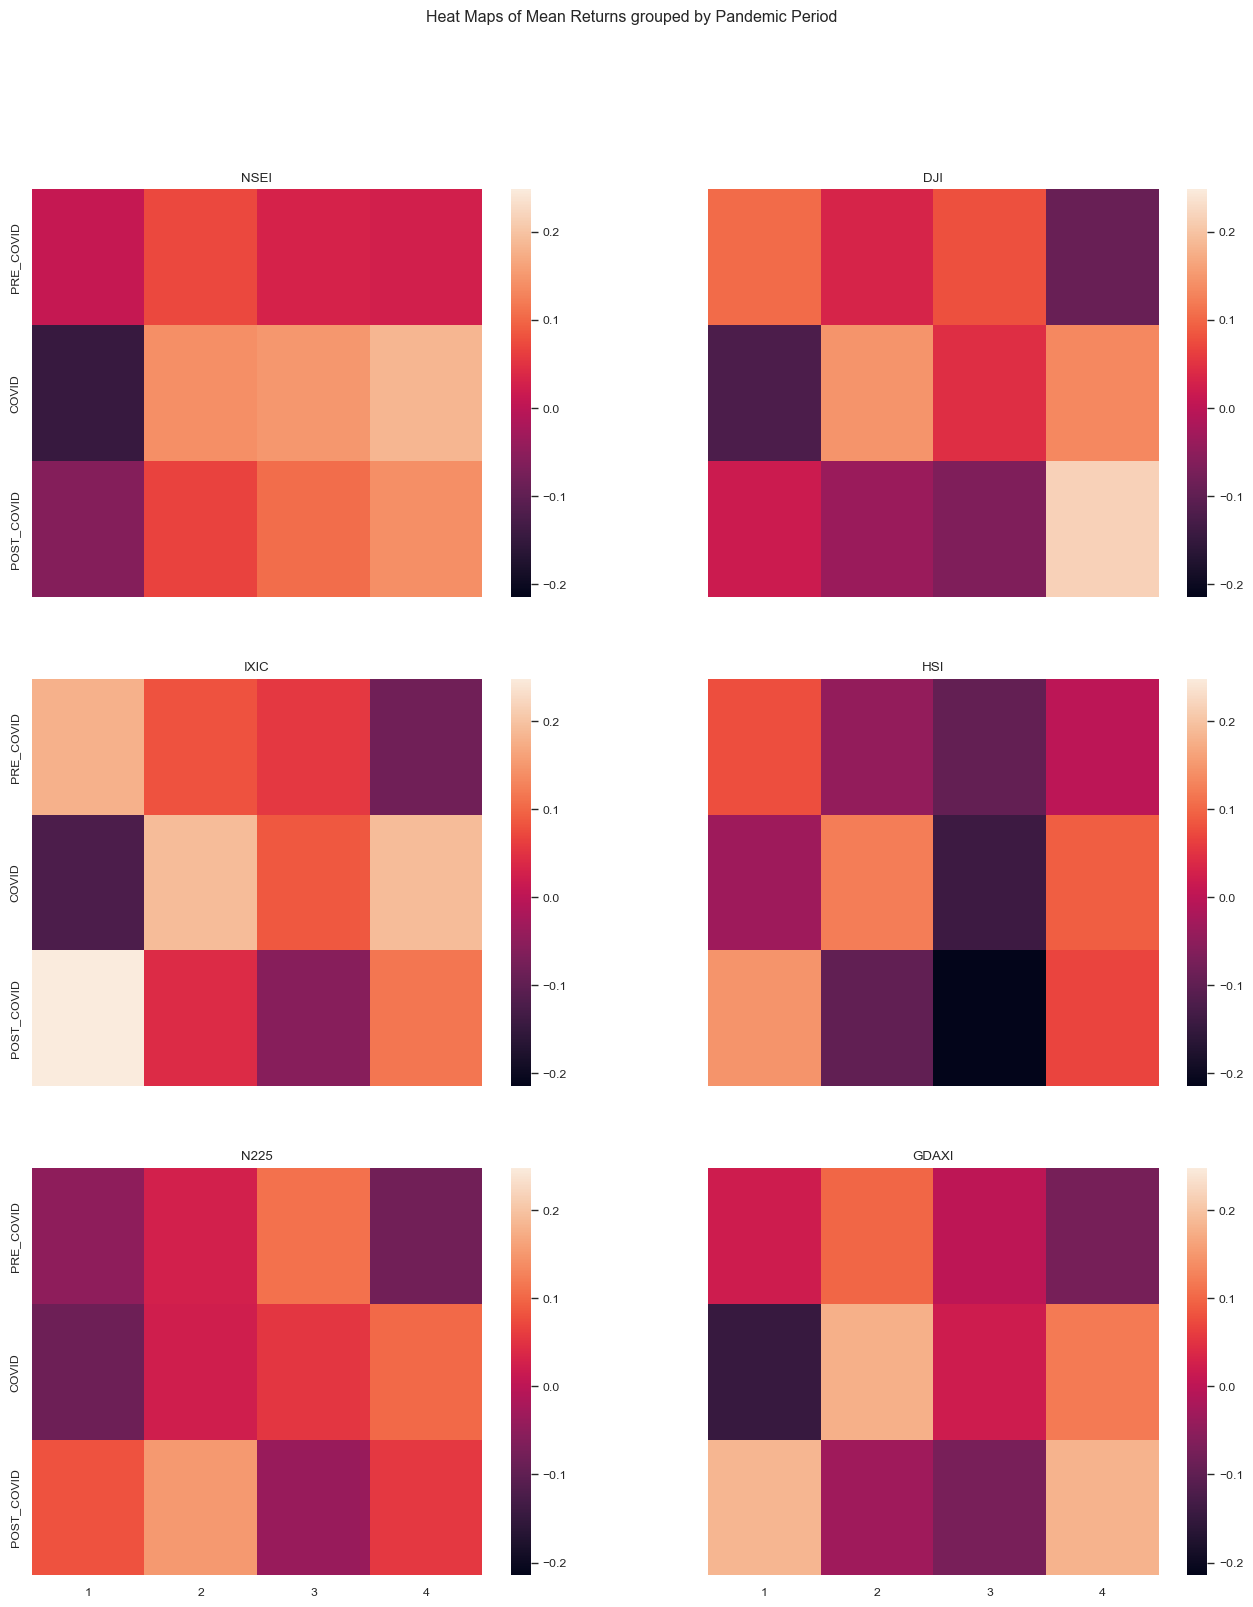

In [391]:
#| label: heat-maps-mean-daily-returns-covid

performance_analytics_heat_maps(master, "PANDEMIC", "Heat Maps of Mean Returns grouped by Pandemic Period", aggfunc = "mean")

Again, NSEI appears to be the most consistent of all indexes. All indexes have bad first quarters during the Pandemic, but improve post Covid.

Next we look at heatmaps by Pandemic period and quarter showing median returns:

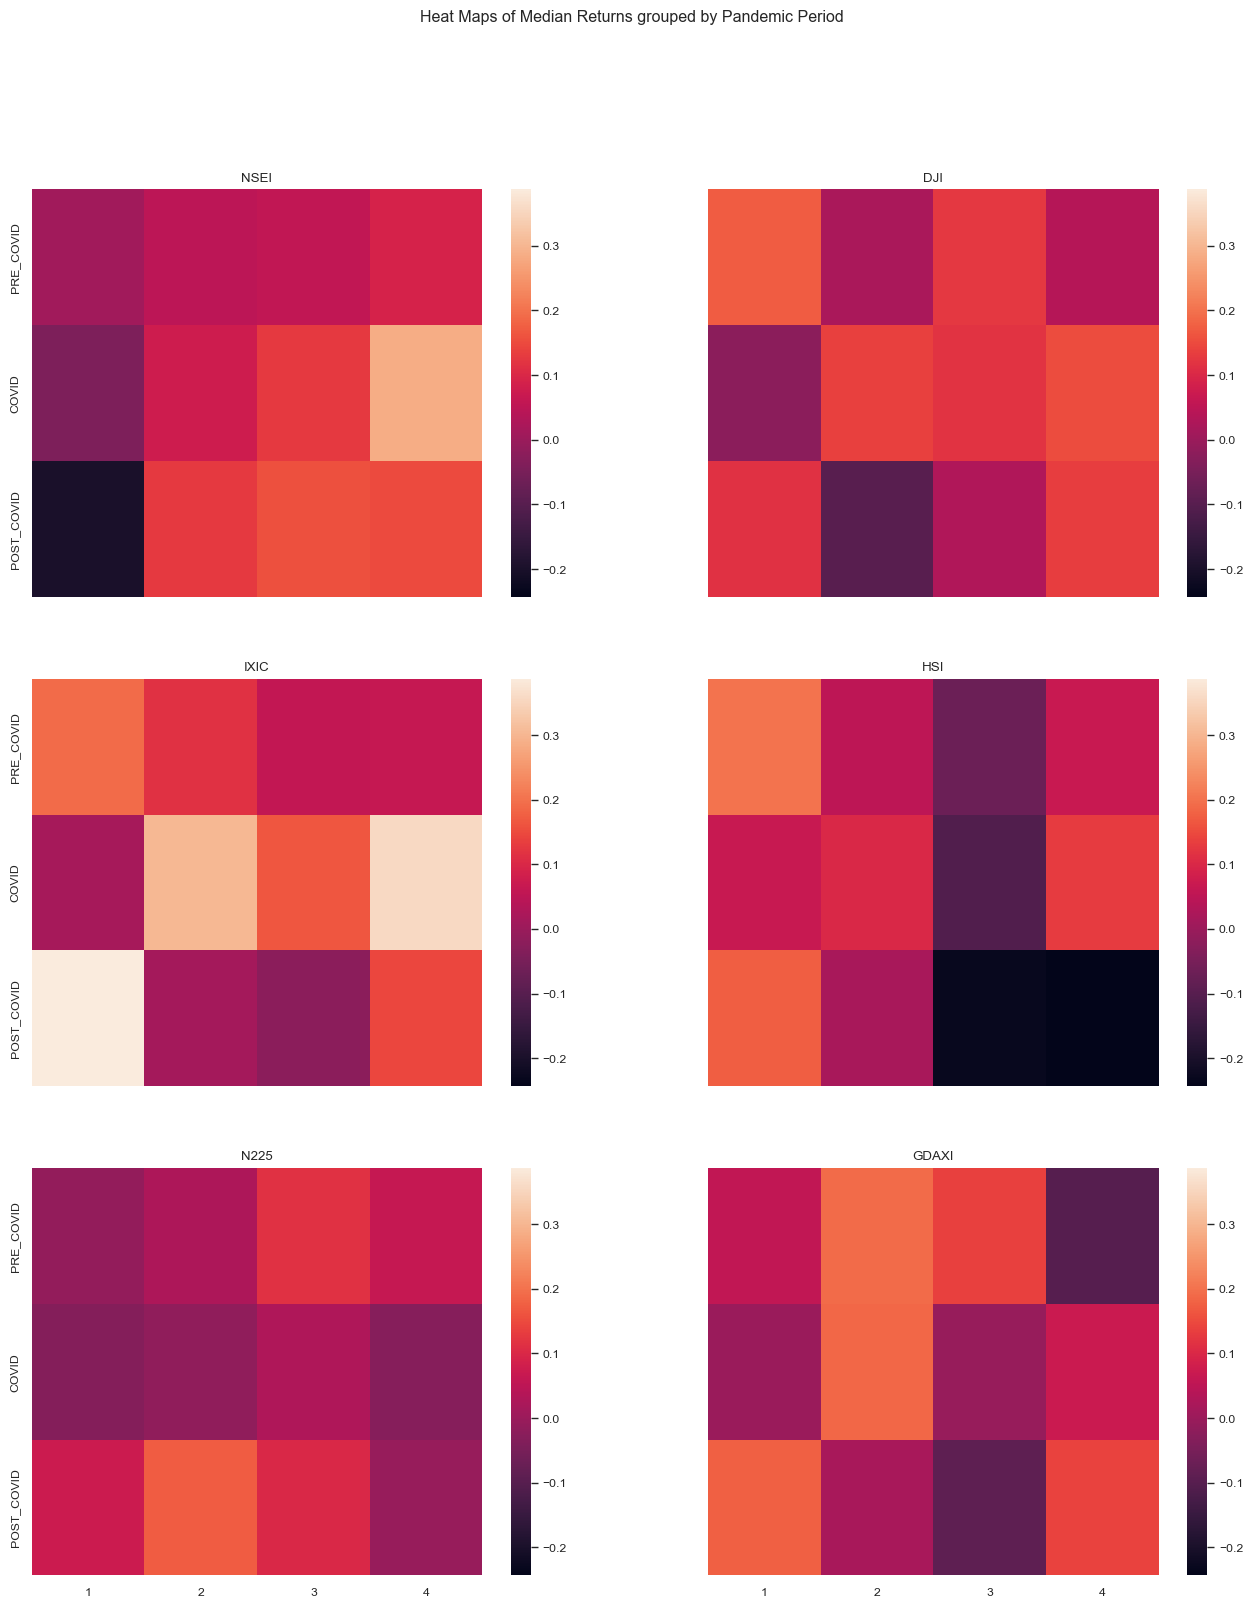

In [392]:
#| label: heat-maps-median-daily-returns-covid

performance_analytics_heat_maps(master, "PANDEMIC", "Heat Maps of Median Returns grouped by Pandemic Period")

Median returns tells a similar story over the Pandemic period - HSI in particular appears to have had the worst recovery.

Next, we try to estimate the time taken for each of the indexes to return to the Pre Covid levels - my approach is to 
find how many days it takes for each index to reach a value greater than or equal to the Pre Covid mean returns value:

In [393]:
#| label: return-to-pre-covid-levels

for i in range(6):
    pre_covid  = master.loc[(master['PANDEMIC'] == 'PRE_COVID'),  [COLUMNS[i]]]
    post_covid = master.loc[(master['PANDEMIC'] == 'POST_COVID'), [COLUMNS[i]]]

    mean_pre   = pre_covid.values.mean()
    post_count = np.where(post_covid[COLUMNS[i]].ge(mean_pre).values == True)[0][0]
    post_date  = post_covid.index[post_covid[COLUMNS[i]].ge(mean_pre)][0].date()

    print(f"{INDICES[i].rjust(5)} returned to pre-covid levels (mean {mean_pre: 2.4f}) on {post_date} after {post_count} trading day(s)")

 NSEI returned to pre-covid levels (mean  0.0334) on 2022-05-16 after 7 trading day(s)
  DJI returned to pre-covid levels (mean  0.0337) on 2022-05-13 after 6 trading day(s)
 IXIC returned to pre-covid levels (mean  0.0619) on 2022-05-10 after 3 trading day(s)
  HSI returned to pre-covid levels (mean -0.0126) on 2022-05-11 after 4 trading day(s)
 N225 returned to pre-covid levels (mean  0.0001) on 2022-05-06 after 1 trading day(s)
GDAXI returned to pre-covid levels (mean  0.0114) on 2022-05-10 after 3 trading day(s)


Interestingly, N225 returned to it's Pre Covid level after just 1 day.

Lets define NSEI_OPEN_DIR as 1 if NSEI Open at time t > NSEI Close at time t - 1, and 0 otherwise:

In [394]:
master["NSEI_OPEN_DIR"] = np.where(master["NSEI_OPEN"] > master["NSEI_CLOSE"].shift(), 1, 0)

Lets look at the percentages of NSEI_OPEN_DIR = 1 by year:

In [395]:
table1 = master.groupby("YEAR", observed = False)[["NSEI_OPEN_DIR"]].sum()
table2 = master.groupby("YEAR", observed = False)[["NSEI_OPEN_DIR"]].count()
table  = ((table1["NSEI_OPEN_DIR"] / table2["NSEI_OPEN_DIR"]) * 100).round(2)

print("\nNifty Fifty Daily Movement\n")
print(f"\n{table}\n")


Nifty Fifty Daily Movement


YEAR
2018    70.38
2019    69.23
2020    70.61
2021    71.65
2022    59.23
2023    67.31
Name: NSEI_OPEN_DIR, dtype: float64



With the exception of 2022, every year has around 70% where NSEI_OPEN_DIR = 1.

Next we look at the indices for each category of NSEI_OPEN_DIR:

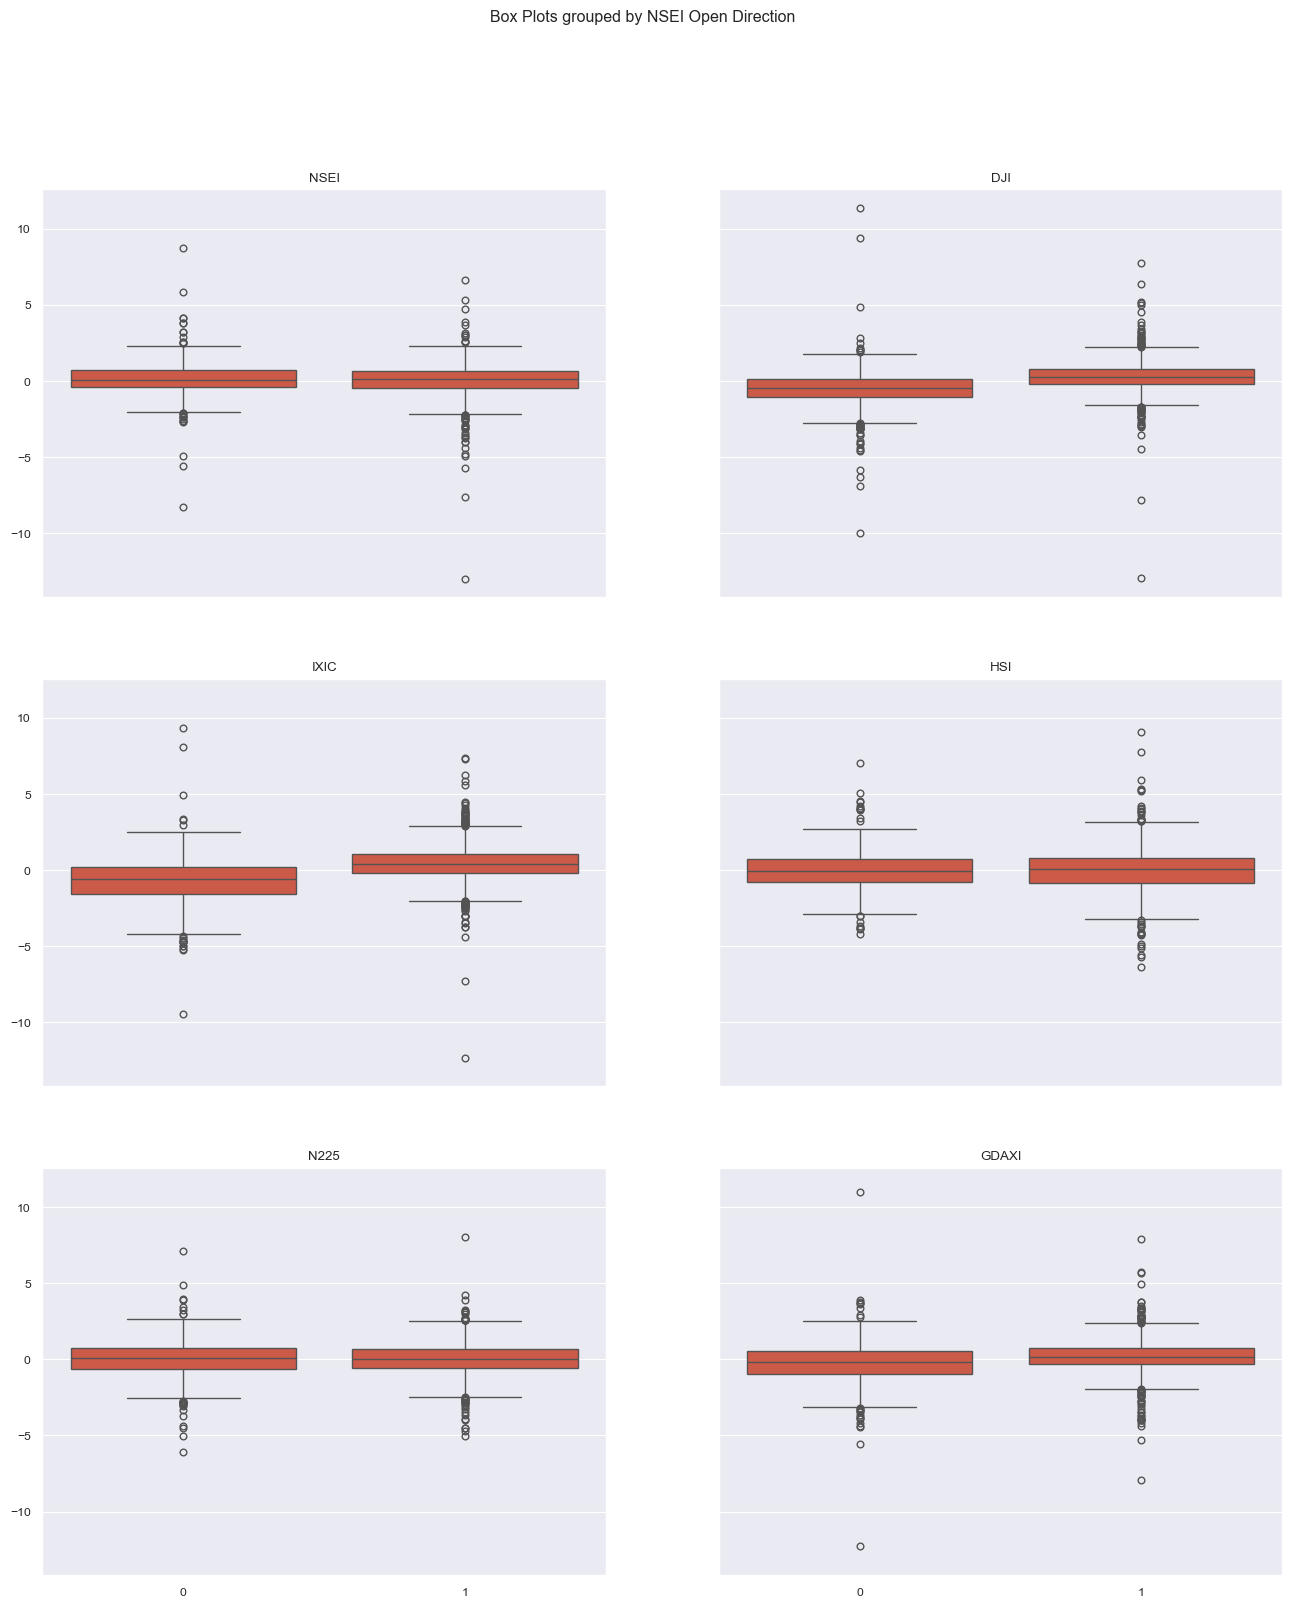

In [396]:
#| label: box-plots-daily-returns-grouped-by-open-dir

fig, axes = plt.subplots(3, 2, figsize = (16, 18), sharex = True, sharey = True)
fig.suptitle("Box Plots grouped by NSEI Open Direction")

for index in range(6):
    axes[index // 2, index % 2].set_title(INDICES[index])
    sns.boxplot(x = master["NSEI_OPEN_DIR"], y = master[COLUMNS[index]].shift(), ax = axes[index // 2, index % 2])
    axes[index // 2, index % 2].set_xlabel("")
    axes[index // 2, index % 2].set_ylabel("")

we look at VIX separately - as it requires a different scale:

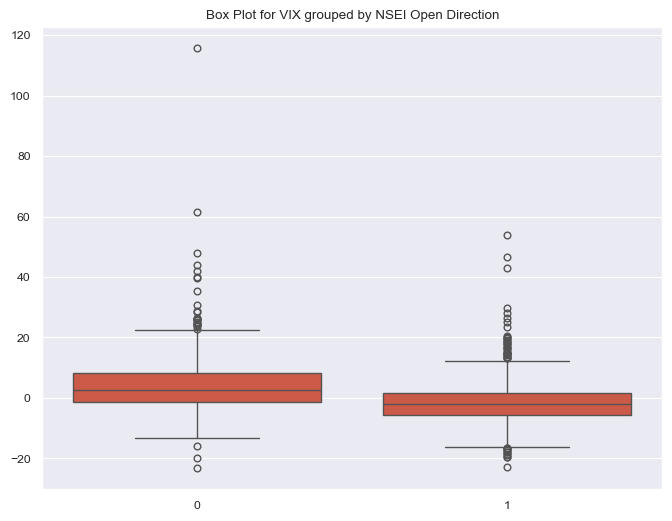

In [397]:
#| label: box-plots-vix-daily-return-grouped-by-open-dir

plt.figure(figsize = (8, 6))

sns.boxplot(x = master["NSEI_OPEN_DIR"], y = master[COLUMNS[6]].shift())

plt.title(f"Box Plot for {INDICES[6]} grouped by NSEI Open Direction")
plt.xlabel("")
plt.ylabel("")

plt.show()

All of the box plots look consistent across each categroy of NSEI_OPEN_DIR, with the exceptions of IXIC and VIX.

## Phase 3 - Training a Logistic Model

Before proceeding with modelling NSEI_OPEN_DIR, lets define, and add, some indicators and ratios:

In [398]:
RATIOS     = ["NSEI_HL_RATIO", "DJI_HL_RATIO"]
INDICATORS = ["NSEI_RSI", "DJI_RSI", "NSEI_TSI", "DJI_TSI"]
ALL_COLS   = COLUMNS + RATIOS + INDICATORS

Lets add NSEI_HL_RATIO and DJI_HL_RATIO:

In [399]:
master["NSEI_HL_RATIO"] = master["NSEI_HIGH"] / master["NSEI_LOW"]
master["DJI_HL_RATIO"]  = master["DJI_HIGH"]  / master["DJI_LOW"]

Lets add some technical indicators - RSI and TSI for NSEI and DJI:

In [400]:
master["NSEI_RSI"] = ta.momentum.rsi(master["NSEI_CLOSE"])
master["DJI_RSI"]  = ta.momentum.rsi(master["DJI_CLOSE"])

master["NSEI_TSI"] = ta.momentum.tsi(master["NSEI_CLOSE"])
master["DJI_TSI"]  = ta.momentum.tsi(master["DJI_CLOSE"])

Lets create a data frame containing all the data we will be working with:

In [401]:
data = pd.concat([master["NSEI_OPEN_DIR"].shift(-1), master[ALL_COLS]], axis = 1)
data.dropna(inplace = True)
data.head()

,NSEI_OPEN_DIR,NSEI_DAILY_RETURNS,DJI_DAILY_RETURNS,IXIC_DAILY_RETURNS,HSI_DAILY_RETURNS,N225_DAILY_RETURNS,GDAXI_DAILY_RETURNS,VIX_DAILY_RETURNS,NSEI_HL_RATIO,DJI_HL_RATIO,NSEI_RSI,DJI_RSI,NSEI_TSI,DJI_TSI
Date,,,,,,,,,,,,,,
2018-02-22,1.0,-0.141862,0.664177,-0.112772,-1.483242,-1.066738,-0.068803,-6.493512,1.005502,1.012146,35.462139,46.645122,-30.229045,-9.335285
2018-02-23,1.0,1.043559,1.392128,1.765585,0.973627,0.719252,0.175574,-11.912391,1.009854,1.011394,43.991068,52.167111,-27.688141,-7.175461
2018-02-26,1.0,0.872647,1.577556,1.145773,0.740168,1.191496,0.346449,-4.184352,1.006915,1.013160,50.003304,57.597238,-23.576140,-3.663260
2018-02-27,0.0,-0.267418,-1.163939,-1.227654,-0.729999,1.066320,-0.289850,17.658227,1.008959,1.015449,48.278103,52.762870,-20.700940,-2.074670
2018-02-28,0.0,-0.582229,-1.498739,-0.782232,-1.355797,-1.436450,-0.439373,6.777839,1.007069,1.022129,44.673823,47.319430,-19.286991,-2.368269


Lets split our data into features (X) and labels (y):

In [402]:
X = data[ALL_COLS]
y = data['NSEI_OPEN_DIR']

And lets add an intercept to the features:

In [403]:
X.insert(loc = 0, column = "Intercept", value = 1)

Now we spit our data into training and testing sets - with an 80 / 20 train / test split:

In [404]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1337)

We define a function that will prune any features that are either found to be insignificant, or that are found to be collinear:

In [405]:
def prune(X, y, verbose = True):
    dropped = []
    while True:
        model = Logit(y, X).fit(disp = 0)

        insignificant = [p for p in zip(model.pvalues.index[1:], model.pvalues[1:]) if p[1] > 0.05]

        values   = [variance_inflation_factor(model.model.exog, i) for i in range(1, model.model.exog.shape[1])]
        colinear = [val for val in zip(model.model.exog_names[1:], values) if val[1] > 5]

        if insignificant:
            insignificant.sort(key = lambda p: -p[1])

            if verbose:
                print(f"dropping {insignificant[0][0]} with p-value {insignificant[0][1]}")

            X = X.drop([insignificant[0][0]], axis = 1)
            dropped.append(insignificant[0][0])

        elif colinear:
            colinear.sort(key = lambda c: -c[1])

            if verbose:
                print(f"dropping {colinear[0][0]} with vif {colinear[0][1]}")

            X = X.drop([colinear[0][0]], axis = 1)
            dropped.append(colinear[0][0])

        else:
            return model, dropped


model, dropped = prune(X_train, y_train)

dropping DJI_DAILY_RETURNS with p-value 0.7234766099770011
dropping GDAXI_DAILY_RETURNS with p-value 0.6162105670376612
dropping NSEI_HL_RATIO with p-value 0.4277618505298021
dropping DJI_HL_RATIO with p-value 0.1563055988923202
dropping NSEI_DAILY_RETURNS with p-value 0.13281329048460666
dropping NSEI_TSI with vif 5.865700460659149
dropping NSEI_RSI with p-value 0.7783762272653001


The function outputs a list of pruned features, together with the associated p-value or vif value. 
The function returns the pruned model, together with a list of pruned feature names.

Lets look at the summary of the model returned:

In [406]:
#| label: logistic-model-summary

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          NSEI_OPEN_DIR   No. Observations:                 1220
Model:                          Logit   Df Residuals:                     1213
Method:                           MLE   Df Model:                            6
Date:                Wed, 10 Jul 2024   Pseudo R-squ.:                  0.1375
Time:                        19:08:10   Log-Likelihood:                -660.02
converged:                       True   LL-Null:                       -765.23
Covariance Type:            nonrobust   LLR p-value:                 1.141e-42
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -1.4041      0.656     -2.139      0.032      -2.690      -0.118
IXIC_DAILY_RETURNS     0.4552      0.075      6.093      0.000       0.309       0.602
HSI_DAILY_RETURNS     -0.1395      0.053     -2.632      0.008      -0.243      -0.036
N225_DAILY_RETURNS    -0.1960      0.068     -2.897      0.004      -0.329      -0.063
VIX_DAILY_RETURNS     -0.0397      0.013     -3.054      0.002      -0.065      -0.014
DJI_RSI                0.0447      0.013      3.415      0.001       0.019       0.070
DJI_TSI               -0.0205      0.008     -2.660      0.008      -0.036      -0.005
======================================================================================
"""

And now lets look at the list of dropped feattures:

In [407]:
#| label: logistic-model-dropped-features

print("\n".join(dropped))

DJI_DAILY_RETURNS
GDAXI_DAILY_RETURNS
NSEI_HL_RATIO
DJI_HL_RATIO
NSEI_DAILY_RETURNS
NSEI_TSI
NSEI_RSI


And lets also look at the variance inflation factors for each of the retained features:

In [408]:
#| label: logistic-model-vif

vif_data = pd.DataFrame()
vif_data["Feature"] = model.model.exog_names[1:]
vif_data["VIF"]     = [variance_inflation_factor(model.model.exog, i) for i in range(1, model.model.exog.shape[1])]
vif_data

,Feature,VIF
0,IXIC_DAILY_RETURNS,2.073867
1,HSI_DAILY_RETURNS,1.244922
2,N225_DAILY_RETURNS,1.353286
3,VIX_DAILY_RETURNS,1.994009
4,DJI_RSI,4.850250
5,DJI_TSI,4.379409


As we can see, all retained features have a vif of less than 5. 

Let us define a function to plot ROC curves which we will use throughout this report:

In [409]:
def performance_analytics_roc_curve(fpr, tpr, title = "ROC Curve"):
    plt.figure(figsize = (8, 6))

    plt.plot(fpr, tpr, label = 'ROC Curve')
    plt.plot([0, 1], [0, 1], 'k--', label = 'Random Guess')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])

    plt.title(title)
    plt.xlabel('FPR')
    plt.ylabel('TPR')

    plt.legend(loc = 'lower right')
    plt.show()

Let us plot the ROC curve for the training data:

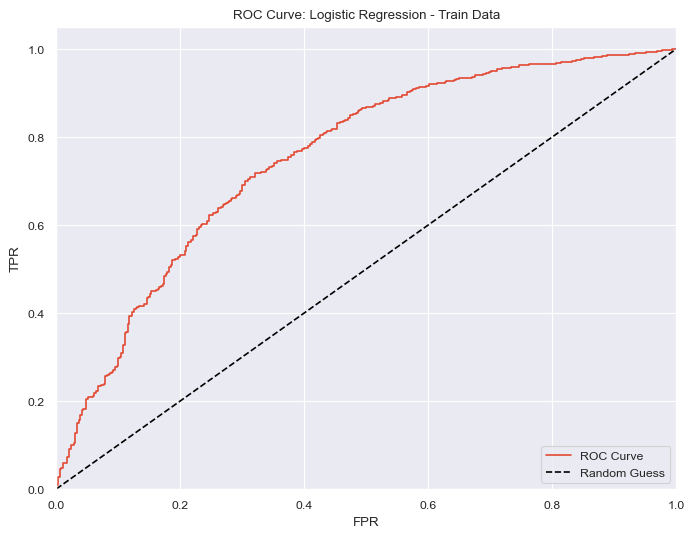

In [410]:
#| label: logistic-model-roc-curve-train-data

y_pred = model.predict(X_train.drop(dropped, axis = 1))
fpr, tpr, thresholds = roc_curve(y_train, y_pred)

performance_analytics_roc_curve(fpr, tpr, title = "ROC Curve: Logistic Regression - Train Data")

Let us find the AUC for the training data:

In [411]:
#| label: logistic-model-auc-train-data

train_auc_roc = roc_auc_score(y_train, y_pred)
print(f'Train Data - AUC ROC: {train_auc_roc}')

Train Data - AUC ROC: 0.7529115595469844


Now we find the optimal threshold that balances sensitivity and specificity:

In [412]:
optimal_threshold = round(thresholds[np.argmax(tpr - fpr)], 3)
print(f'Optimal Threshold: {optimal_threshold}')

Optimal Threshold: 0.684


Next we generate a classification report for the training data with the optimal threshold:

In [413]:
#| label: logistic-model-classification-report-train-data

y_pred_class = np.where(y_pred <= optimal_threshold, 0, 1)
print(classification_report(y_train, y_pred_class))

              precision    recall  f1-score   support

         0.0       0.53      0.68      0.60       391
         1.0       0.83      0.72      0.77       829

    accuracy                           0.70      1220
   macro avg       0.68      0.70      0.68      1220
weighted avg       0.73      0.70      0.71      1220



Next we generate a confusion matrix for the training data with the optimal threshold:

In [414]:
#| label: logistic-model-confusion-matrix-train-data

table_train = pd.crosstab(y_pred_class, y_train)
print(table_train)

NSEI_OPEN_DIR  0.0  1.0
row_0                  
0              265  234
1              126  595


And finally, we obtain the sensitivity and specificity for the training data:

In [415]:
#| label: logistic-model-sens-spec-train-data

sensitivity = round((table_train.iloc[1, 1] / (table_train.iloc[0, 1] + table_train.iloc[1, 1])) * 100, 2)
specificity = round((table_train.iloc[0, 0] / (table_train.iloc[0, 0] + table_train.iloc[1, 0])) * 100, 2)

print(f"Train Data - Sensitivity: {sensitivity}%")
print(f"Train Data - Specificity: {specificity}%")

Train Data - Sensitivity: 71.77%
Train Data - Specificity: 67.77%


Now we do the same for the test data - starting with obtaining the ROC curve:

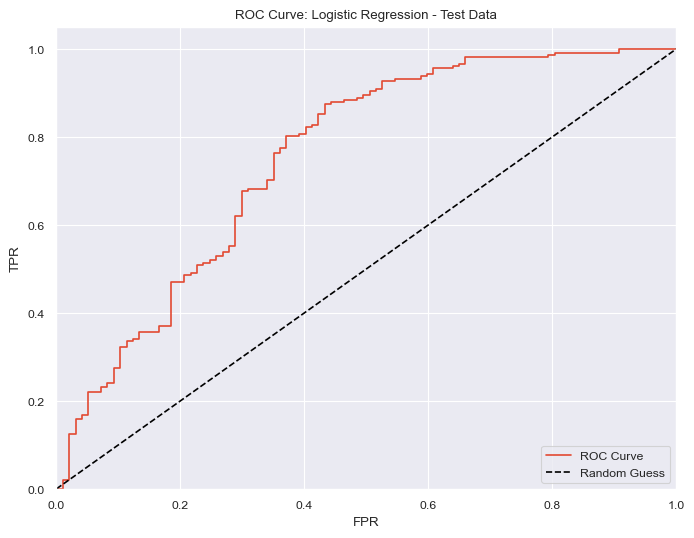

In [416]:
#| label: logistic-model-roc-curve-test-data

y_test_pred = model.predict(X_test.drop(dropped, axis = 1))
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)

performance_analytics_roc_curve(fpr, tpr, title = "ROC Curve: Logistic Regression - Test Data")

Next, we obtain the AUC for the test data:

In [417]:
#| label: logistic-model-auc-test-data

test_auc_roc = roc_auc_score(y_test, y_test_pred)
print(f'Test Data - AUC ROC: {test_auc_roc}')

Test Data - AUC ROC: 0.7520816812053925


Next we generate a classification report for the test data (with the previously calculated optimal threshold):

In [418]:
#| label: logistic-model-classification-report-test-data

y_test_pred_class = np.where(y_test_pred <= optimal_threshold,  0, 1)
print(classification_report(y_test, y_test_pred_class))

              precision    recall  f1-score   support

         0.0       0.53      0.65      0.58        97
         1.0       0.82      0.73      0.77       208

    accuracy                           0.70       305
   macro avg       0.67      0.69      0.67       305
weighted avg       0.72      0.70      0.71       305



Next we generate a confusion matrix for the test data (with the previously calculated optimal threshold):

In [419]:
#| label: logistic-model-confusion-matrix-test-data

table_test = pd.crosstab(y_test_pred_class, y_test)
print(table_test)

NSEI_OPEN_DIR  0.0  1.0
row_0                  
0               63   57
1               34  151


And finally, we obtain the sensitivity and specificity for the test data:

In [420]:
#| label: logistic-model-sens-spec-test-data

sensitivity = round((table_test.iloc[1, 1] / (table_test.iloc[0, 1] + table_test.iloc[1, 1])) * 100, 2)
specificity = round((table_test.iloc[0, 0] / (table_test.iloc[0, 0] + table_test.iloc[1, 0])) * 100, 2)

print(f"Test Data - Sensitivity: {sensitivity}%")
print(f"Test Data - Specificity: {specificity}%")

Test Data - Sensitivity: 72.6%
Test Data - Specificity: 64.95%


Reviewing the AUC for both train and test data - we see they are very close implying consistency in the performance of the models:

In [421]:
#| label: logistic-model-auc-comparison

print(f'Train Data - AUC ROC: {train_auc_roc}')
print(f' Test Data - AUC ROC: {test_auc_roc}')

Train Data - AUC ROC: 0.7529115595469844
 Test Data - AUC ROC: 0.7520816812053925


But the accuracy of the model is not great. We could obtain better results by selecting a different classification model.

## Phase 4 - Compare Models 

Next, we compare the performance of a number of different models. We first implement two functions that will help us:

In [422]:
def model_metrics_plots(X_train, X_test, y_train, y_test, model, name = "MODEL"):
    model.fit(X_train, y_train)

    y_train_pred_prob = model.predict_proba(X_train)
    train_fpr, train_tpr, _ = roc_curve(y_train, y_train_pred_prob[:, 1])

    y_test_pred_prob = model.predict_proba(X_test)
    test_fpr, test_tpr, _ = roc_curve(y_test, y_test_pred_prob[:, 1])

    fig, axes = plt.subplots(1, 2, figsize = (16, 6))
    fig.suptitle("ROC Curves")

    axes[0].set_title(f"{name} - Train Data")
    axes[0].plot(train_fpr, train_tpr, label = 'ROC Curve')
    axes[0].plot([0, 1], [0, 1], 'k--', label = 'Random Guess')
    axes[0].legend(loc = 'lower right')
    axes[0].set_xlabel("FPR")
    axes[0].set_ylabel("TPR")
    axes[0].set_xlim([0.0, 1.0])
    axes[0].set_ylim([0.0, 1.05])

    axes[1].set_title(f"{name} - Test Data")
    axes[1].plot(test_fpr, test_tpr, label = 'ROC Curve')
    axes[1].plot([0, 1], [0, 1], 'k--', label = 'Random Guess')
    axes[1].legend(loc = 'lower right')
    axes[1].set_xlabel("FPR")
    axes[1].set_ylabel("TPR")
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])



def model_metrics_data(X_train, X_test, y_train, y_test, model, name = "MODEL"):
    model.fit(X_train, y_train)

    y_train_pred_prob = model.predict_proba(X_train)
    train_fpr, train_tpr, thresholds = roc_curve(y_train, y_train_pred_prob[:, 1])

    y_test_pred_prob = model.predict_proba(X_test)

    optimal_threshold = round(thresholds[np.argmax(train_tpr - train_fpr)], 3)

    train_auc_roc = roc_auc_score(y_train, y_train_pred_prob[:, 1])
    y_train_pred_class = np.where(y_train_pred_prob[:, 1] <= optimal_threshold,  0, 1)
    train_table = pd.crosstab(y_train_pred_class, y_train)
    train_sensitivity = round((train_table.iloc[1, 1] / (train_table.iloc[0, 1] + train_table.iloc[1, 1])) * 100, 2)
    train_specificity = round((train_table.iloc[0, 0] / (train_table.iloc[0, 0] + train_table.iloc[1, 0])) * 100, 2)

    test_auc_roc = roc_auc_score(y_test, y_test_pred_prob[:, 1])
    y_test_pred_class = np.where(y_test_pred_prob[:, 1] <= optimal_threshold,  0, 1)
    test_table = pd.crosstab(y_test_pred_class, y_test)
    test_sensitivity = round((test_table.iloc[1, 1] / (test_table.iloc[0, 1] + test_table.iloc[1, 1])) * 100, 2)
    test_specificity = round((test_table.iloc[0, 0] / (test_table.iloc[0, 0] + test_table.iloc[1, 0])) * 100, 2)

    print()
    print(f"{name}")
    print()

    print(f"\nTrain Data - Classification Report:\n")
    print(classification_report(y_train, y_train_pred_class))
    print(f"\nTrain Data - Confusion Matrix:\n\n{train_table}\n")

    print(f"\n Test Data - Classification Report:\n")
    print(classification_report(y_test, y_test_pred_class))
    print(f"\n Test Data - Confusion Matrix:\n\n{test_table}\n")

    print()

    print(f"Train Data - Sensitivity for cut-off {optimal_threshold}: {train_sensitivity}%")
    print(f" Test Data - Sensitivity for cut-off {optimal_threshold}: {test_sensitivity}%\n")

    print(f"Train Data - Specificity for cut-off {optimal_threshold}: {train_specificity}%")
    print(f" Test Data - Specificity for cut-off {optimal_threshold}: {test_specificity}%\n")

    print(f"Train Data - AUC ROC: {train_auc_roc}")
    print(f" Test Data - AUC ROC: {test_auc_roc}\n")

We prepare our data:

In [423]:
X = data[ALL_COLS].values
y = data['NSEI_OPEN_DIR'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1337)

We once again look at a Logistic model, which will become our baseline:

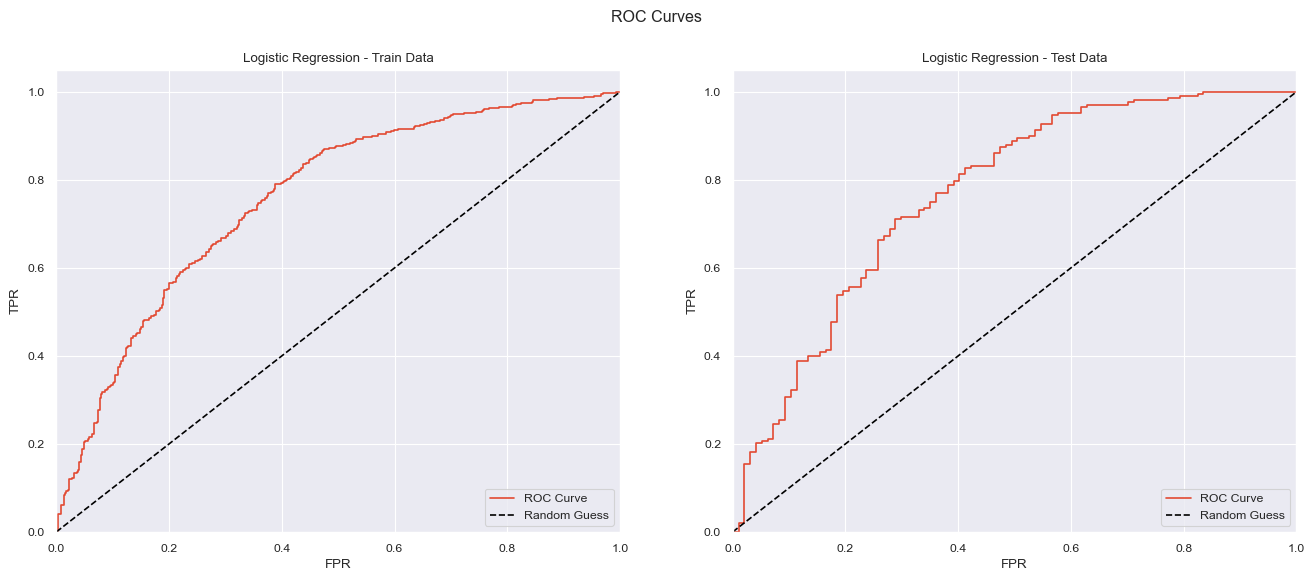

In [424]:
#| label: model-metrics-plots-logistic

model_log = LogisticRegression(max_iter = 1000, random_state = 1337)
model_metrics_plots(X_train, X_test, y_train, y_test, model_log, name = "Logistic Regression")

and the corresponding data:

In [425]:
#| label: model-metrics-data-logistic

model_metrics_data(X_train, X_test, y_train, y_test, model_log, name = "Logistic Regression")


Logistic Regression


Train Data - Classification Report:

              precision    recall  f1-score   support

         0.0       0.58      0.61      0.59       391
         1.0       0.81      0.79      0.80       829

    accuracy                           0.73      1220
   macro avg       0.70      0.70      0.70      1220
weighted avg       0.74      0.73      0.73      1220


Train Data - Confusion Matrix:

col_0  0.0  1.0
row_0          
0      239  174
1      152  655


 Test Data - Classification Report:

              precision    recall  f1-score   support

         0.0       0.56      0.63      0.59        97
         1.0       0.82      0.77      0.79       208

    accuracy                           0.72       305
   macro avg       0.69      0.70      0.69       305
weighted avg       0.73      0.72      0.73       305


 Test Data - Confusion Matrix:

col_0  0.0  1.0
row_0          
0       61   48
1       36  160


Train Data - Sensitivity for cut-off 0.654: 79.01%


We notice that the scikit-learn LogisticRegression model slightly outperforms the Statsmodels Logit model. We use the Statsmodels 
Logit model when we need to perform analysis of features. Moving to scikit-learn's LogisticRegression model  after the model has 
been finalised is acceptable.

Next we look at Naive Bayes:

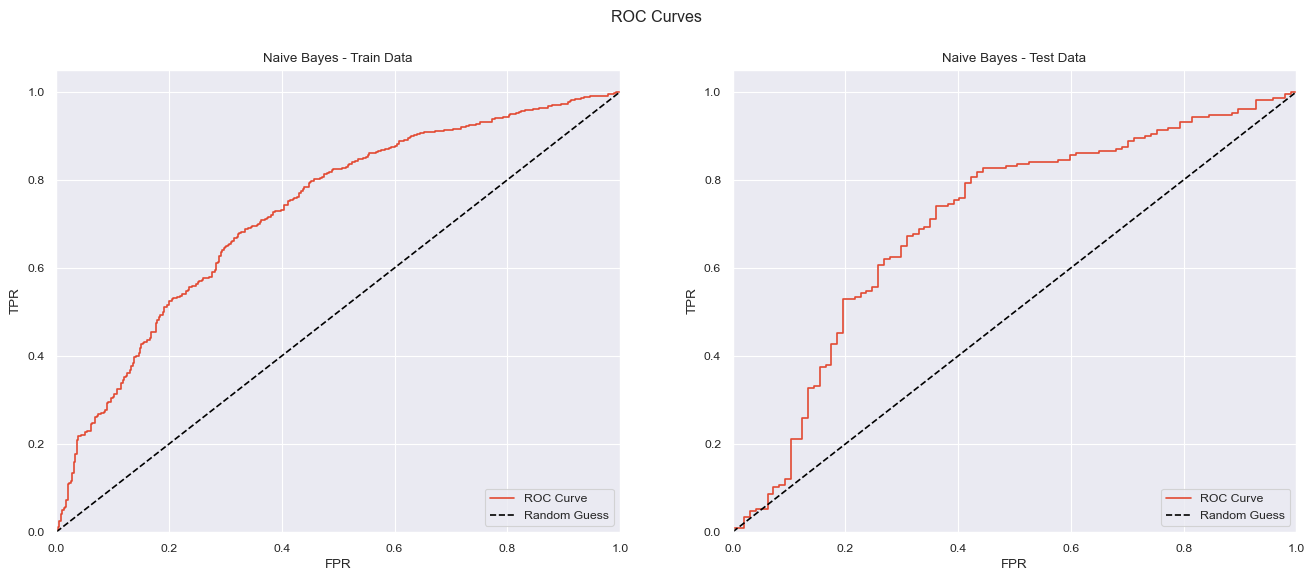

In [426]:
#| label: model-metrics-plots-naive-bayes

model_nb = GaussianNB()
model_metrics_plots(X_train, X_test, y_train, y_test, model_nb, name = "Naive Bayes")

and the corresponding data:

In [427]:
#| label: model-metrics-data-naive-bayes

model_metrics_data(X_train, X_test, y_train, y_test, model_nb, name = "Naive Bayes")


Naive Bayes


Train Data - Classification Report:

              precision    recall  f1-score   support

         0.0       0.50      0.68      0.57       391
         1.0       0.82      0.68      0.74       829

    accuracy                           0.68      1220
   macro avg       0.66      0.68      0.66      1220
weighted avg       0.71      0.68      0.69      1220


Train Data - Confusion Matrix:

col_0  0.0  1.0
row_0          
0      264  266
1      127  563


 Test Data - Classification Report:

              precision    recall  f1-score   support

         0.0       0.47      0.70      0.56        97
         1.0       0.82      0.62      0.71       208

    accuracy                           0.65       305
   macro avg       0.64      0.66      0.63       305
weighted avg       0.71      0.65      0.66       305


 Test Data - Confusion Matrix:

col_0  0.0  1.0
row_0          
0       68   78
1       29  130


Train Data - Sensitivity for cut-off 0.916: 67.91%
 Test Da

The Naive Bayes model clearly performs worse than the Logistic model. Next, we look at a KNN classifier:

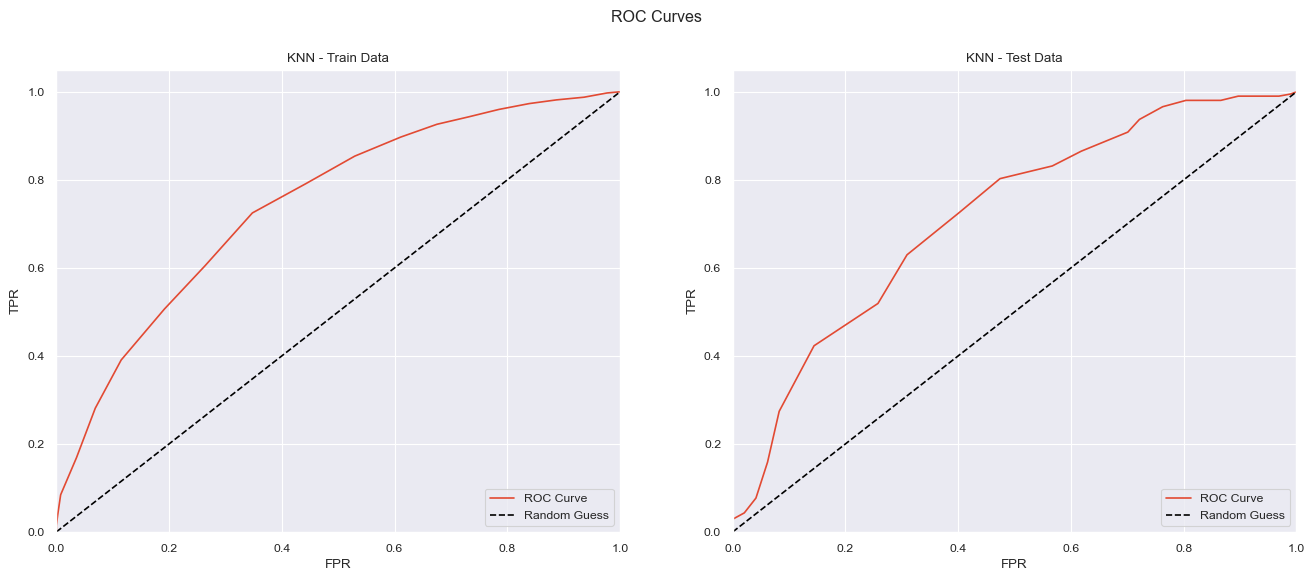

In [428]:
#| label: model-metrics-plots-knn

scaler = StandardScaler()
scaler.fit(X_train)

model_knn = KNeighborsClassifier(leaf_size = 10, n_neighbors = 30)
model_metrics_plots(X_train, X_test, y_train, y_test, model_knn, name = "KNN")

and the corresponding data:

In [429]:
#| label: model-metrics-data-knn

model_metrics_data(X_train, X_test, y_train, y_test, model_knn, name = "KNN")


KNN


Train Data - Classification Report:

              precision    recall  f1-score   support

         0.0       0.47      0.74      0.57       391
         1.0       0.83      0.60      0.70       829

    accuracy                           0.65      1220
   macro avg       0.65      0.67      0.64      1220
weighted avg       0.71      0.65      0.66      1220


Train Data - Confusion Matrix:

col_0  0.0  1.0
row_0          
0      288  328
1      103  501


 Test Data - Classification Report:

              precision    recall  f1-score   support

         0.0       0.47      0.69      0.56        97
         1.0       0.81      0.63      0.71       208

    accuracy                           0.65       305
   macro avg       0.64      0.66      0.63       305
weighted avg       0.70      0.65      0.66       305


 Test Data - Confusion Matrix:

col_0  0.0  1.0
row_0          
0       67   77
1       30  131


Train Data - Sensitivity for cut-off 0.7: 60.43%
 Test Data - Sensi

The KNN model also performs badly when compared to the Logistic model. Next, we look at a Decision Tree classifier:

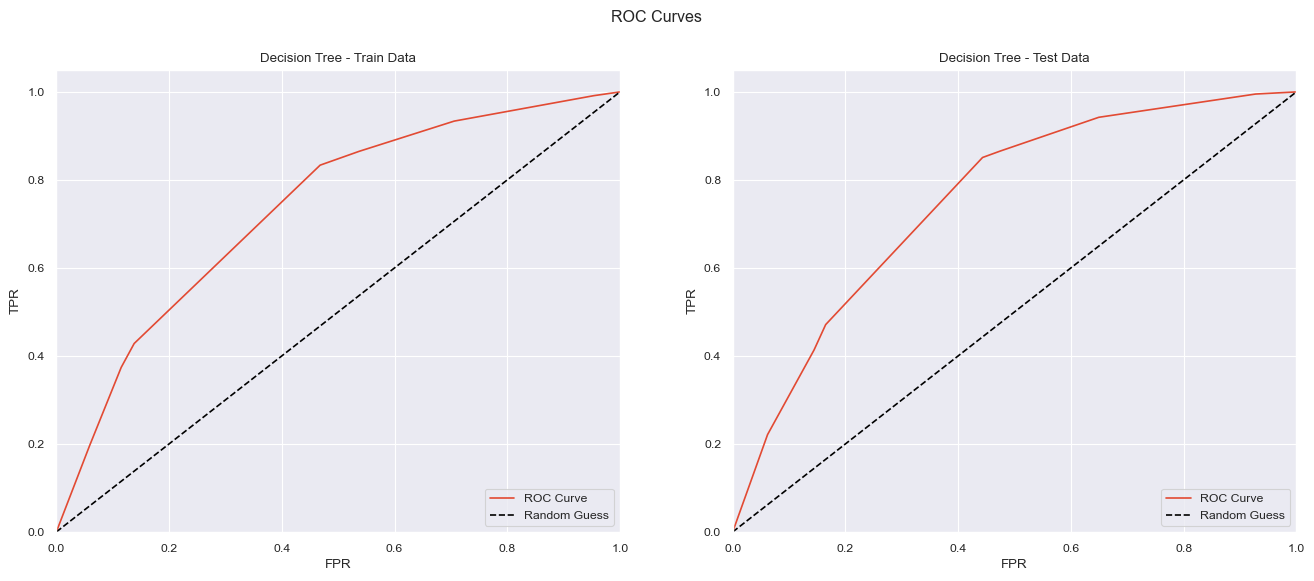

In [430]:
#| label: model-metrics-plots-decision-tree

model_dt = DecisionTreeClassifier(max_depth = 10, min_samples_split = 0.4, splitter = "random", random_state = 1337)
model_metrics_plots(X_train, X_test, y_train, y_test, model_dt, name = "Decision Tree")

and the data:

In [431]:
#| label: model-metrics-data-decision-tree

model_metrics_data(X_train, X_test, y_train, y_test, model_dt, name = "Decision Tree")


Decision Tree


Train Data - Classification Report:

              precision    recall  f1-score   support

         0.0       0.42      0.86      0.56       391
         1.0       0.87      0.43      0.57       829

    accuracy                           0.57      1220
   macro avg       0.64      0.65      0.57      1220
weighted avg       0.72      0.57      0.57      1220


Train Data - Confusion Matrix:

col_0  0.0  1.0
row_0          
0      337  474
1       54  355


 Test Data - Classification Report:

              precision    recall  f1-score   support

         0.0       0.42      0.84      0.56        97
         1.0       0.86      0.47      0.61       208

    accuracy                           0.59       305
   macro avg       0.64      0.65      0.59       305
weighted avg       0.72      0.59      0.59       305


 Test Data - Confusion Matrix:

col_0  0.0  1.0
row_0          
0       81  110
1       16   98


Train Data - Sensitivity for cut-off 0.723: 42.82%
 Test 

The Decision Tree classifier performs very badly - with an accuracy of around 55%. Next, we look at a Random Forest classifier:

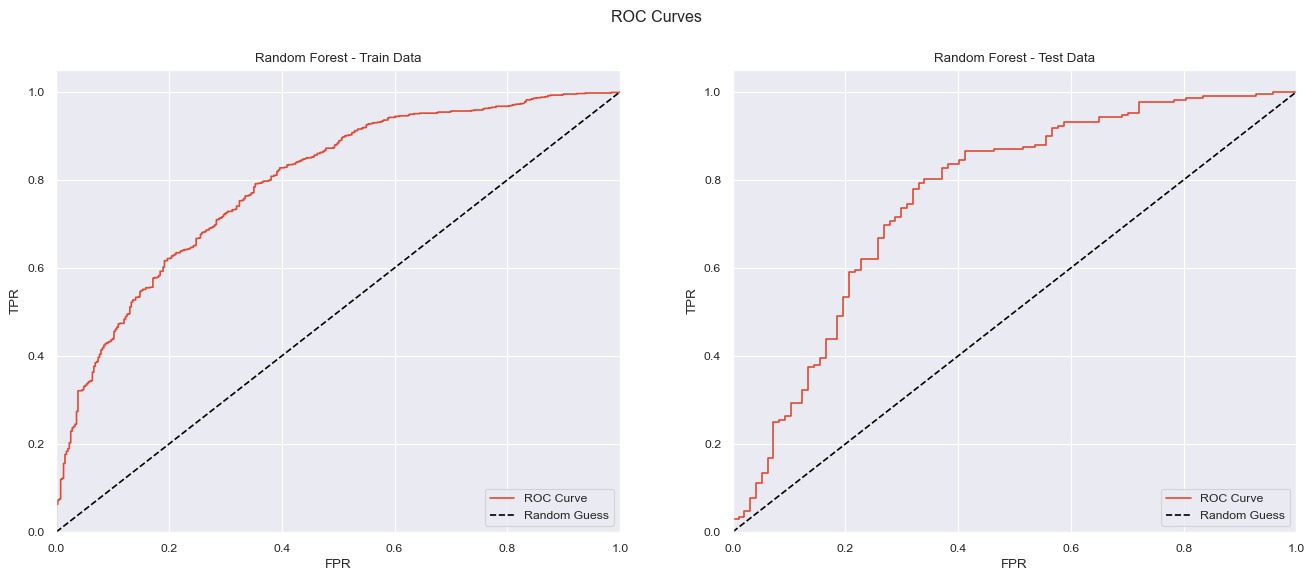

In [432]:
#| label: model-metrics-plots-random-forest

model_rf = RandomForestClassifier(max_depth = 10, min_samples_split = 0.2, random_state = 1337)
model_metrics_plots(X_train, X_test, y_train, y_test, model_rf, name = "Random Forest")

and the data:

In [433]:
#| label: model-metrics-data-random-forest

model_metrics_data(X_train, X_test, y_train, y_test, model_rf, name = "Random Forest")


Random Forest


Train Data - Classification Report:

              precision    recall  f1-score   support

         0.0       0.59      0.65      0.62       391
         1.0       0.83      0.79      0.81       829

    accuracy                           0.74      1220
   macro avg       0.71      0.72      0.71      1220
weighted avg       0.75      0.74      0.75      1220


Train Data - Confusion Matrix:

col_0  0.0  1.0
row_0          
0      253  175
1      138  654


 Test Data - Classification Report:

              precision    recall  f1-score   support

         0.0       0.60      0.67      0.63        97
         1.0       0.84      0.79      0.81       208

    accuracy                           0.75       305
   macro avg       0.72      0.73      0.72       305
weighted avg       0.76      0.75      0.76       305


 Test Data - Confusion Matrix:

col_0  0.0  1.0
row_0          
0       65   43
1       32  165


Train Data - Sensitivity for cut-off 0.638: 78.89%
 Test 

The Random Forest classifier performs reasonably well, but not as well as the baseline Logistic model. Next, we look at Support Vector Machine classifier:

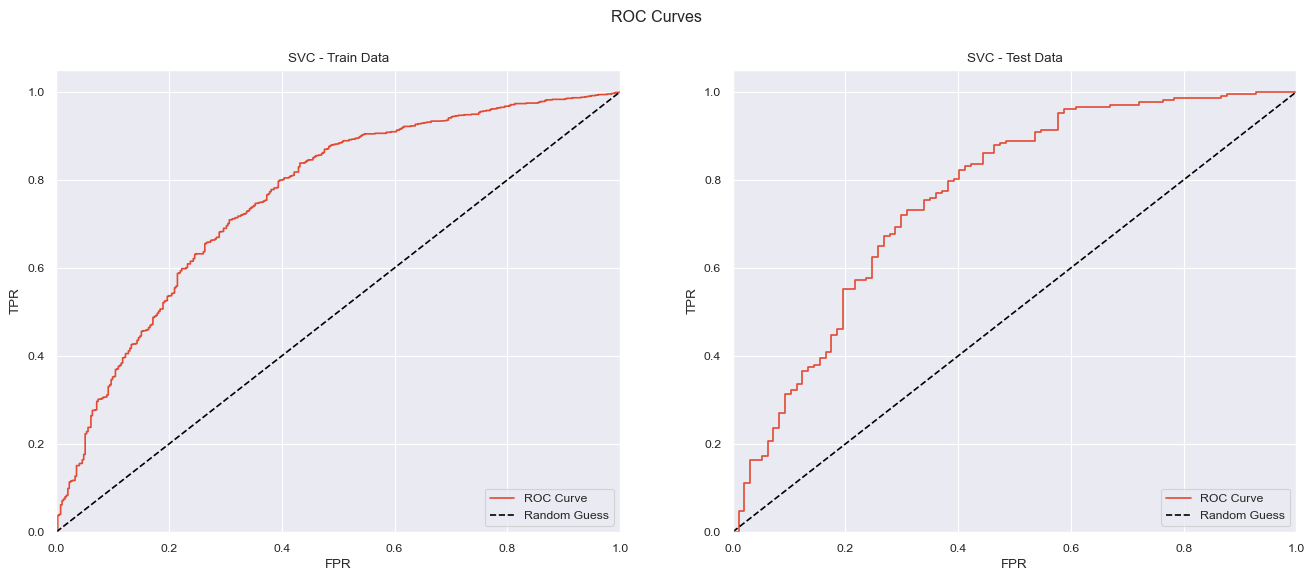

In [434]:
#| label: model-metrics-plots-svm

model_svm = SVC(C = 1, kernel = "linear", probability = True, random_state = 1337)
model_metrics_plots(X_train, X_test, y_train, y_test, model_svm, name = "SVC")

and the data:

In [435]:
#| label: model-metrics-data-svm

model_metrics_data(X_train, X_test, y_train, y_test, model_svm, name = "SVC")


SVC


Train Data - Classification Report:

              precision    recall  f1-score   support

         0.0       0.62      0.56      0.59       391
         1.0       0.80      0.84      0.82       829

    accuracy                           0.75      1220
   macro avg       0.71      0.70      0.70      1220
weighted avg       0.74      0.75      0.75      1220


Train Data - Confusion Matrix:

col_0  0.0  1.0
row_0          
0      219  133
1      172  696


 Test Data - Classification Report:

              precision    recall  f1-score   support

         0.0       0.61      0.59      0.60        97
         1.0       0.81      0.82      0.82       208

    accuracy                           0.75       305
   macro avg       0.71      0.70      0.71       305
weighted avg       0.75      0.75      0.75       305


 Test Data - Confusion Matrix:

col_0  0.0  1.0
row_0          
0       57   37
1       40  171


Train Data - Sensitivity for cut-off 0.642: 83.96%
 Test Data - Sen

This is the best performing model yet with a consistent accuracy of 75% and consistent AUC of ~0.76. Next, we move on to Multilayer Perceptron classifier:

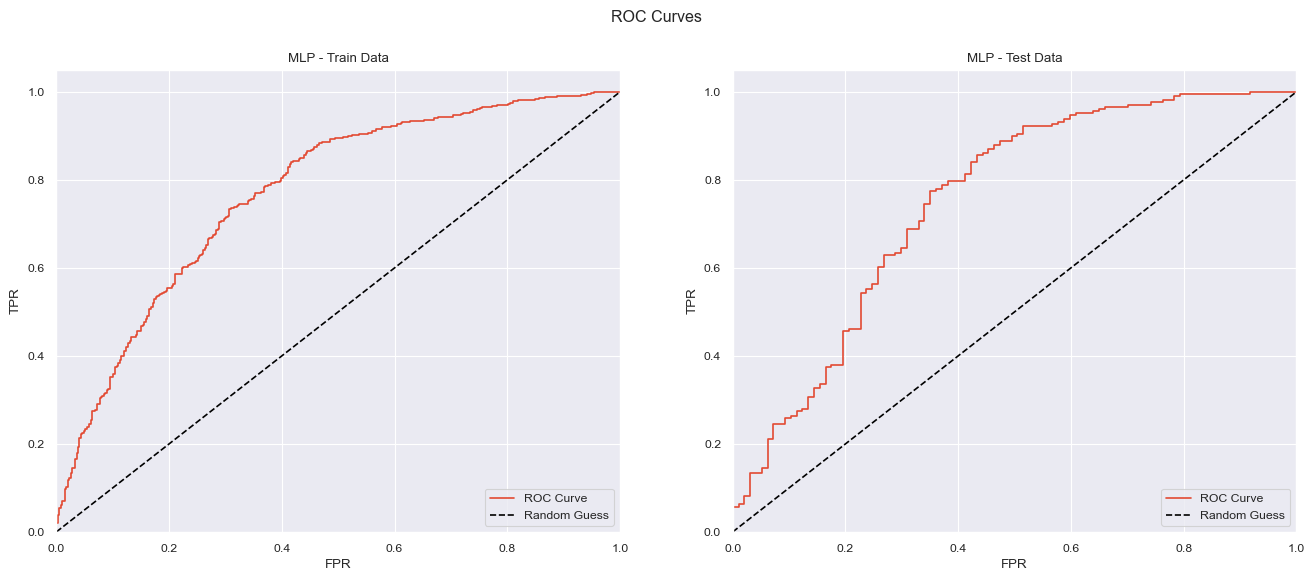

In [436]:
#| label: model-metrics-plots-mlp

scaler = MinMaxScaler()
scaler.fit(X_train)

model_mlp = MLPClassifier(alpha = 0.001, max_iter = 1000, random_state = 1337)
model_metrics_plots(scaler.transform(X_train), scaler.transform(X_test), y_train, y_test, model_mlp, name = "MLP")

and the data:

In [437]:
#| label: model-metrics-data-mlp

model_metrics_data(scaler.transform(X_train), scaler.transform(X_test), y_train, y_test, model_mlp, name = "MLP")


MLP


Train Data - Classification Report:

              precision    recall  f1-score   support

         0.0       0.55      0.69      0.61       391
         1.0       0.84      0.73      0.78       829

    accuracy                           0.72      1220
   macro avg       0.69      0.71      0.70      1220
weighted avg       0.74      0.72      0.73      1220


Train Data - Confusion Matrix:

col_0  0.0  1.0
row_0          
0      271  221
1      120  608


 Test Data - Classification Report:

              precision    recall  f1-score   support

         0.0       0.52      0.66      0.58        97
         1.0       0.82      0.71      0.76       208

    accuracy                           0.70       305
   macro avg       0.67      0.69      0.67       305
weighted avg       0.72      0.70      0.70       305


 Test Data - Confusion Matrix:

col_0  0.0  1.0
row_0          
0       64   60
1       33  148


Train Data - Sensitivity for cut-off 0.712: 73.34%
 Test Data - Sen

The Multilayer Perceptron model does reasonably well, but not as well as the SVM classifier. Overall, the SVM classifier 
performs the best. 

Lets see if we can imporove on the SVM classifier with a deep learning model implemented using PyTorch. First, lets check 
to see if cuda is available:

In [438]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Next we create a deep learning model: 

In [439]:
class DL(nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim):
        super(DL, self).__init__()

        self.input  = nn.Linear(input_dim, hidden_dim)
        self.act_in = nn.ReLU()

        self.hidden1 = nn.Linear(hidden_dim, hidden_dim)
        self.act1 = nn.ReLU()
        self.hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.act2 = nn.ReLU()
        self.hidden3 = nn.Linear(hidden_dim, hidden_dim)
        self.act3 = nn.ReLU()
        self.hidden4 = nn.Linear(hidden_dim, hidden_dim)
        self.act4 = nn.ReLU()
        self.hidden5 = nn.Linear(hidden_dim, hidden_dim)
        self.act5 = nn.ReLU()
        self.hidden6 = nn.Linear(hidden_dim, hidden_dim)
        self.act6 = nn.ReLU()
        self.hidden7 = nn.Linear(hidden_dim, hidden_dim)
        self.act7 = nn.ReLU()

        self.output  = nn.Linear(hidden_dim, output_dim)
        self.act_out = nn.Sigmoid()

    def forward(self, x):
        x = self.act_in(self.input(x))

        x = self.act1(self.hidden1(x))
        x = self.act2(self.hidden2(x))
        x = self.act3(self.hidden3(x))
        x = self.act4(self.hidden4(x))
        x = self.act5(self.hidden5(x))
        x = self.act6(self.hidden6(x))
        x = self.act7(self.hidden7(x))

        return self.act_out(self.output(x))

Next we scale the data, and create a train test split: 

In [440]:
scaler = MinMaxScaler(feature_range = (0, 1))

X = scaler.fit_transform(data[ALL_COLS].values) 
y = data['NSEI_OPEN_DIR'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1337)

Next we convert the data into tensors, and move them onto the cuda device if available:

In [441]:
X_train = torch.from_numpy(X_train).type(torch.Tensor)
X_test  = torch.from_numpy(X_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)

if torch.cuda.is_available():
    X_train = X_train.cuda()
    X_test  = X_test.cuda()
    y_train = y_train.cuda()

Next define our model parameters, create an instance of our model, and define our loss criterion and optimiser:

In [442]:
input_dim  = X.shape[1]
hidden_dim = 64
output_dim = 1

model     = DL(input_dim, hidden_dim, output_dim)
model     = model.to(device)

criterion = nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr = 0.0001)

Next we create functions to train our model, with and without batches, and make use of it:

In [443]:
def train(X, y, model, criterion, optimiser, epochs = 500):
    losses = []

    for epoch in range(epochs):
        out  = model(X)
        loss = criterion(out, y)

        losses.append(loss.item())

        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        if epoch % 10 == 9:
            print(f"Epoch {epoch + 1:>3} - MSE: {loss.item()}")

    return losses

def train_batched(X, y, model, criterion, optimiser, epochs = 500, batch_size = 20, shuffle = False):
    losses = []

    dataset    = utils.TensorDataset(X, y)
    dataloader = utils.DataLoader(dataset, batch_size = batch_size, shuffle = shuffle)

    for epoch in range(epochs):
        for batch, (X_batch, y_batch) in enumerate(dataloader):
            out  = model(X_batch)
            loss = criterion(out, y_batch)

            losses.append(loss.item())

            optimiser.zero_grad()
            loss.backward()
            optimiser.step()

            if batch % 10 == 9:
                print(f"Epoch {epoch + 1:>3} - Batch {batch + 1:>3} - MSE: {loss.item()}")

    return losses

# losses = train(X_train, y_train[:, None], model, criterion, optimiser)
losses = train_batched(X_train, y_train[:, None], model, criterion, optimiser, batch_size = 100, shuffle = True)

Epoch   1 - Batch  10 - MSE: 0.24581755697727203
Epoch   2 - Batch  10 - MSE: 0.2428935021162033
Epoch   3 - Batch  10 - MSE: 0.24090971052646637
Epoch   4 - Batch  10 - MSE: 0.2452872395515442
Epoch   5 - Batch  10 - MSE: 0.24358420073986053
Epoch   6 - Batch  10 - MSE: 0.2402580976486206
Epoch   7 - Batch  10 - MSE: 0.23894134163856506
Epoch   8 - Batch  10 - MSE: 0.23425158858299255
Epoch   9 - Batch  10 - MSE: 0.22734546661376953
Epoch  10 - Batch  10 - MSE: 0.24289806187152863
Epoch  11 - Batch  10 - MSE: 0.22648021578788757
Epoch  12 - Batch  10 - MSE: 0.2319982498884201
Epoch  13 - Batch  10 - MSE: 0.221490740776062
Epoch  14 - Batch  10 - MSE: 0.2225533127784729
Epoch  15 - Batch  10 - MSE: 0.2453363686800003
Epoch  16 - Batch  10 - MSE: 0.22490368783473969
Epoch  17 - Batch  10 - MSE: 0.22733283042907715
Epoch  18 - Batch  10 - MSE: 0.21217261254787445
Epoch  19 - Batch  10 - MSE: 0.20337630808353424
Epoch  20 - Batch  10 - MSE: 0.2104637324810028
Epoch  21 - Batch  10 - MSE: 

Lets plot the losses:

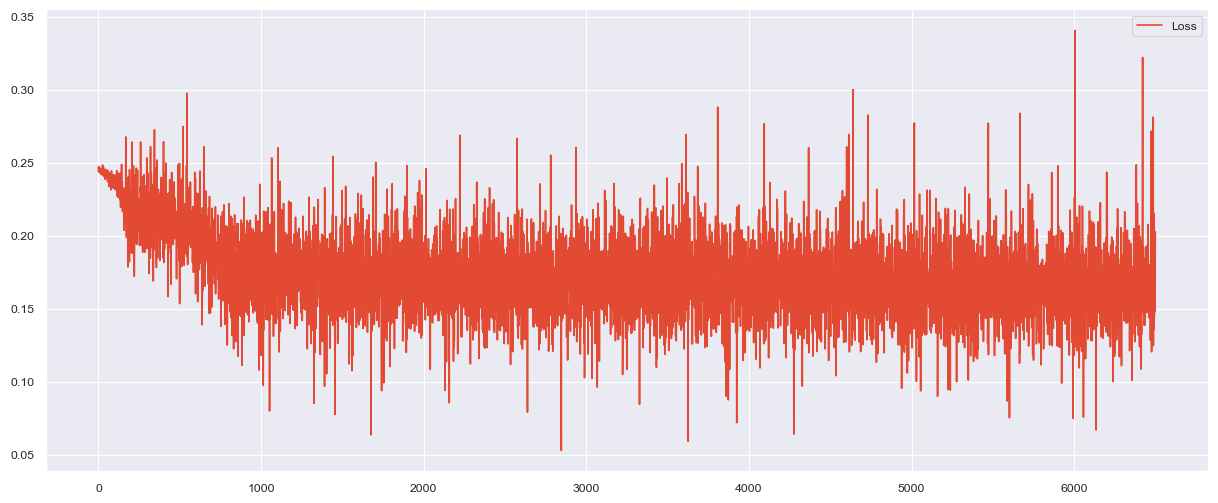

In [444]:
#| label: model-metrics-plots-dl-loss

plt.figure(figsize = (15, 6))
plt.plot(losses, label = "Loss")
plt.legend()
plt.show()

Next lets plot the ROC curve for the training data:

In [445]:
y_train_pred_prob = model(X_train).detach().cpu().numpy()

if torch.cuda.is_available():
    y_train = y_train.cpu()

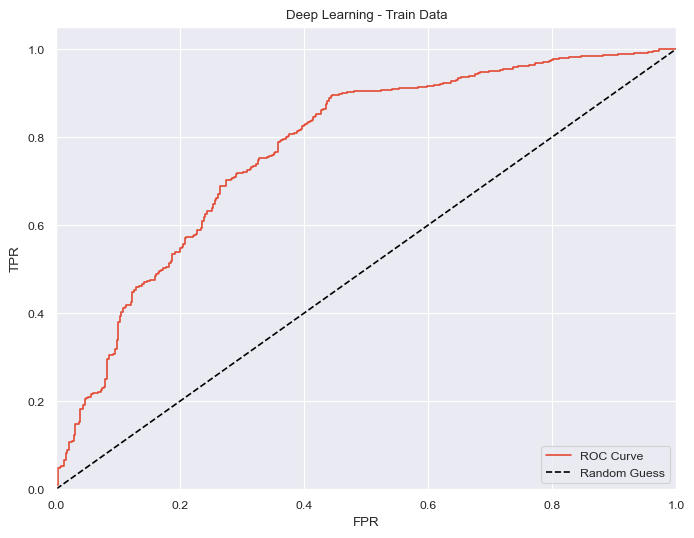

In [446]:
#| label: model-metrics-plots-dl-roc-train

train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_train_pred_prob)

performance_analytics_roc_curve(train_fpr, train_tpr, "Deep Learning - Train Data")

Lets calculate the optimal threshold:

In [447]:
optimal_threshold = round(train_thresholds[np.argmax(train_tpr - train_fpr)], 3)
print(f'Deep Learning - Optimal Threshold: {optimal_threshold}')

Deep Learning - Optimal Threshold: 0.36000001430511475


With the optimal threshold we calculate the AUC for the train data:

In [448]:
train_auc_roc = roc_auc_score(y_train, y_train_pred_prob)
print(f'Deep Learning - AUC ROC: {train_auc_roc}')

Deep Learning - AUC ROC: 0.7720391560410812


Lets look at the classification report for the train data:

In [449]:
y_train_pred_class = np.where(y_train_pred_prob <= optimal_threshold,  0, 1)
print(classification_report(y_train, y_train_pred_class))

              precision    recall  f1-score   support

         0.0       0.71      0.56      0.62       391
         1.0       0.81      0.89      0.85       829

    accuracy                           0.79      1220
   macro avg       0.76      0.73      0.74      1220
weighted avg       0.78      0.79      0.78      1220



The accuracy seems good. Lets look at the confusion matrix for the train data:

In [450]:
table = pd.crosstab(y_train_pred_class[:, 0], y_train)
print(table)

col_0  0.0  1.0
row_0          
0      218   89
1      173  740


And lets look at the sensitivity and specificity for the train data:

In [451]:
sensitivity = round((table.iloc[1, 1] / (table.iloc[0, 1] + table.iloc[1, 1])) * 100, 2)
specificity = round((table.iloc[0, 0] / (table.iloc[0, 0] + table.iloc[1, 0])) * 100, 2)

print(f"Deep Learning - Sensitivity for cut-off {optimal_threshold} is : {sensitivity}%")
print(f"Deep Learning - Specificity for cut-off {optimal_threshold} is : {specificity}%")

Deep Learning - Sensitivity for cut-off 0.36000001430511475 is : 89.26%
Deep Learning - Specificity for cut-off 0.36000001430511475 is : 55.75%


Now lets compare with the test data - we begin with the ROC curve:

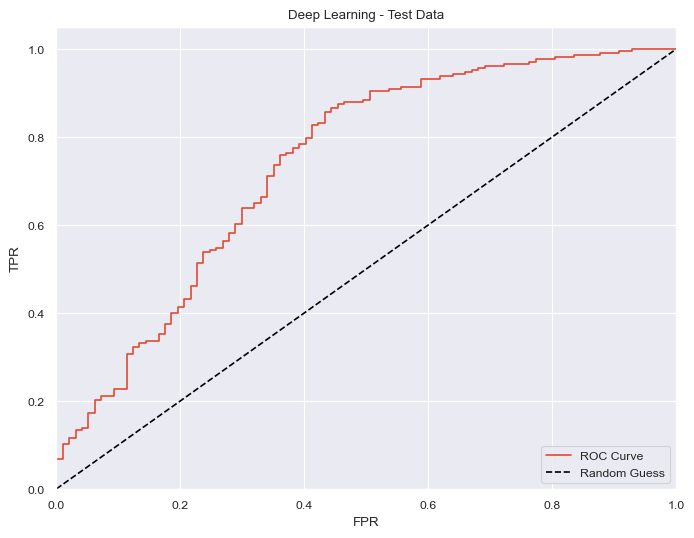

In [452]:
#| label: model-metrics-plots-dl-roc-test

y_test_pred_prob = model(X_test).detach().cpu().numpy()

test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_pred_prob)

performance_analytics_roc_curve(test_fpr, test_tpr, "Deep Learning - Test Data")

Lets calculate the AUC for the test data:

In [453]:
test_auc_roc = roc_auc_score(y_test, y_test_pred_prob)
print(f'Deep Learning - AUC ROC: {test_auc_roc}')

Deep Learning - AUC ROC: 0.7385507533703409


Lets look at the classification report for the test data:

In [454]:
y_test_pred_class = np.where(y_test_pred_prob <= optimal_threshold,  0, 1)
print(classification_report(y_test, y_test_pred_class))

              precision    recall  f1-score   support

         0.0       0.66      0.55      0.60        97
         1.0       0.80      0.87      0.84       208

    accuracy                           0.77       305
   macro avg       0.73      0.71      0.72       305
weighted avg       0.76      0.77      0.76       305



The accuracy seems good. Lets look at the confusion matrix for the test data:

In [455]:
table = pd.crosstab(y_test_pred_class[:, 0], y_test)
print(table)

col_0  0.0  1.0
row_0          
0       53   27
1       44  181


And lets look at the sensitivity and specificity for the test data:

In [456]:
sensitivity = round((table.iloc[1, 1] / (table.iloc[0, 1] + table.iloc[1, 1])) * 100, 2)
specificity = round((table.iloc[0, 0] / (table.iloc[0, 0] + table.iloc[1, 0])) * 100, 2)

print(f"Deep Learning - Sensitivity for cut-off {optimal_threshold} is : {sensitivity}%")
print(f"Deep Learning - Specificity for cut-off {optimal_threshold} is : {specificity}%")

Deep Learning - Sensitivity for cut-off 0.36000001430511475 is : 87.02%
Deep Learning - Specificity for cut-off 0.36000001430511475 is : 54.64%


The results of the PyTorch deep learning model shows potential. The train and test AUC values are slightly 
inconsistent, but the accuracy values are reasonably good for little effort. It might be worth the effort 
to investigate this approach further.

Now we look to see if we can engineer a feature to improve the outcome.

## Phase 5 - Sentiment Analysis

We now turn to Twitter / X data relating to the Nifty 50 index to see if we can mine some sentiment. First we load the tweets and create a data frame:

In [2]:
# with open(os.path.join(os.getcwd(), "Tweets 12-6-24.txt")) as file:
with open(os.path.join(os.getcwd(), "data/tweets/Tweets 12-6-24.txt")) as file:
    tweets = [line.rstrip() for line in file]

data = pd.DataFrame([line for line in tweets if len(line) > 0], columns= ["Tweets"])
data.head()

,Tweets
0,#bankNifty 50100 ce looks good at 70+-2 for a ...
1,"""#market #banknifty #OptionsTrading #optionbuy..."
2,PENNY STOCK MADHUCON PROJECTS LTD cmp-11 FOLLO...
3,#Nifty50 has been in a healthy uptrend since t...
4,#Gravita #livetrading #stockstowatch #stocksin...


Next, we do some basic pre-processing of the data to:

1. transform all words to lowercase
2. remove all punctuation
3. remove all digits
4. remove stopwords

In [3]:
stop_words    = set(stopwords.words('english'))
remove_punc   = str.maketrans('', '', punctuation)
remove_digits = str.maketrans('', '', digits)

def preprocess_tweet(tweet):
    tokens = word_tokenize(tweet.lower().translate(remove_punc).translate(remove_digits))
    return " ".join([word for word in tokens if word not in stop_words])

cleaned = data["Tweets"].apply(preprocess_tweet)
cleaned.head()

0           banknifty ce looks good target nifty nifty
1    market banknifty optionstrading optionbuying t...
2    penny stock madhucon projects ltd cmp followht...
3    nifty healthy uptrend since beginning year did...
4    gravita livetrading stockstowatch stocksinfocu...
Name: Tweets, dtype: object

Next we look at the top 20 words by frequency:

In [4]:
tweet_words = cleaned.str.cat(sep = " ")

freq_dist = nltk.FreqDist(tweet_words.split())
word_freq = pd.DataFrame(freq_dist.most_common(30), columns=["Word", "Freq"])
word_freq.head(30)

,Word,Freq
0,nifty,399
1,banknifty,104
2,stockmarket,71
3,niftybank,45
4,stockmarketindia,44
5,sensex,43
6,stocks,38
7,optionstrading,36
8,bse,34
9,breakoutstocks,31


Lets add "nifty" to the list of stop words and create the cleaned tweets:

In [5]:
stop_words = set(stopwords.words('english')) | set(["nifty"])

data["Cleaned_Tweets"] = data["Tweets"].apply(preprocess_tweet)
data.head()

,Tweets,Cleaned_Tweets
0,#bankNifty 50100 ce looks good at 70+-2 for a ...,banknifty ce looks good target
1,"""#market #banknifty #OptionsTrading #optionbuy...",market banknifty optionstrading optionbuying t...
2,PENNY STOCK MADHUCON PROJECTS LTD cmp-11 FOLLO...,penny stock madhucon projects ltd cmp followht...
3,#Nifty50 has been in a healthy uptrend since t...,healthy uptrend since beginning year didnt bre...
4,#Gravita #livetrading #stockstowatch #stocksin...,gravita livetrading stockstowatch stocksinfocu...


We look again at the top 20 words by frequency:

In [6]:
tweet_words = data["Cleaned_Tweets"].str.cat(sep = " ")

freq_dist = nltk.FreqDist(tweet_words.split())
word_freq = pd.DataFrame(freq_dist.most_common(30), columns=["Word", "Freq"])
word_freq.head(30)

,Word,Freq
0,banknifty,104
1,stockmarket,71
2,niftybank,45
3,stockmarketindia,44
4,sensex,43
5,stocks,38
6,optionstrading,36
7,bse,34
8,breakoutstocks,31
9,trading,30


We visualise these top 20 words by frequency:

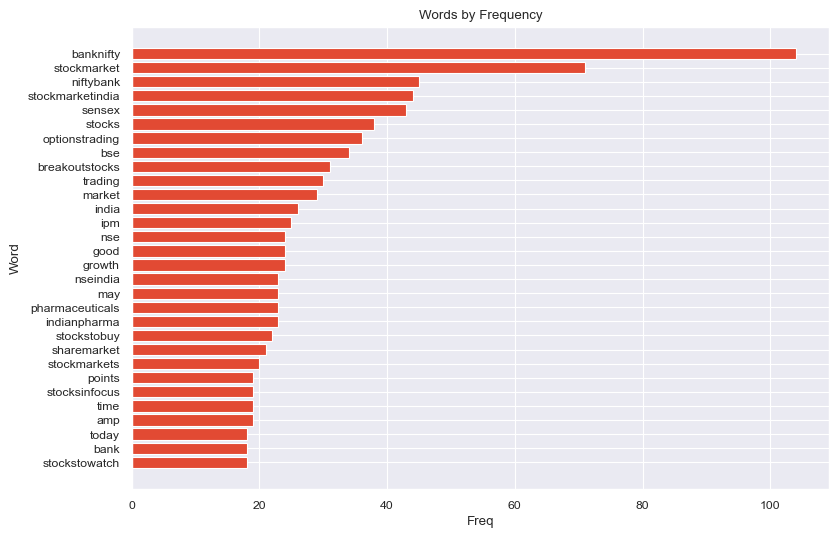

In [7]:
#| label: tweets-words-bar-plot-freq

word_freq = word_freq.sort_values("Freq", ascending = True).reset_index(drop = True)

plt.figure(figsize = (9, 6))
plt.barh(word_freq["Word"], word_freq["Freq"], align = 'center')

plt.title('Words by Frequency')
plt.xlabel('Freq')
plt.ylabel('Word')

plt.show()

Next, we create a word cloud:

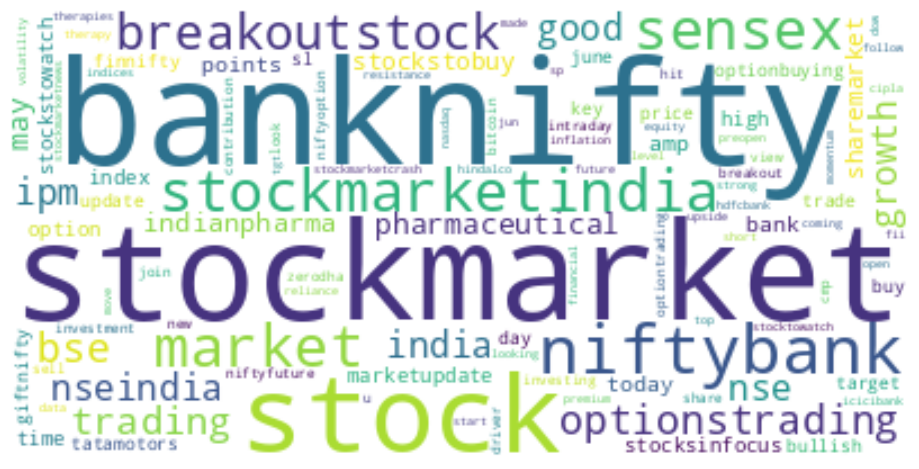

In [8]:
#| label: tweets-words-word-cloud

wordcloud = WordCloud(background_color = "white", collocations = False).generate(tweet_words)

plt.figure(figsize = (9, 6))
plt.imshow(wordcloud, interpolation = "bilinear")

plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

Next, we extract sentiment scores for the tweets:

In [9]:
sia = SentimentIntensityAnalyzer()

polarity_scores = data["Cleaned_Tweets"].apply(lambda x: sia.polarity_scores(x))

data["Positive_Score"] = polarity_scores.apply(lambda x: x["pos"])
data["Negative_Score"] = polarity_scores.apply(lambda x: x["neg"])
data["Neutral_Score"]  = polarity_scores.apply(lambda x: x["neu"])
data["Compound_Score"] = polarity_scores.apply(lambda x: x["compound"])

data.head()

,Tweets,Cleaned_Tweets,Positive_Score,Negative_Score,Neutral_Score,Compound_Score
0,#bankNifty 50100 ce looks good at 70+-2 for a ...,banknifty ce looks good target,0.420,0.000,0.580,0.4404
1,"""#market #banknifty #OptionsTrading #optionbuy...",market banknifty optionstrading optionbuying t...,0.075,0.145,0.780,-0.3400
2,PENNY STOCK MADHUCON PROJECTS LTD cmp-11 FOLLO...,penny stock madhucon projects ltd cmp followht...,0.155,0.000,0.845,0.2960
3,#Nifty50 has been in a healthy uptrend since t...,healthy uptrend since beginning year didnt bre...,0.100,0.198,0.702,-0.3935
4,#Gravita #livetrading #stockstowatch #stocksin...,gravita livetrading stockstowatch stocksinfocu...,0.262,0.000,0.738,0.5994


We look at the summary statistics for the sentiment scores:

In [10]:
scores = data[["Positive_Score", "Negative_Score", "Neutral_Score", "Compound_Score"]]
scores.describe()

,Positive_Score,Negative_Score,Neutral_Score,Compound_Score
count,245.000000,245.000000,245.000000,245.000000
mean,0.116216,0.028490,0.855314,0.172913
std,0.146029,0.071052,0.156892,0.343955
min,0.000000,0.000000,0.213000,-0.807400
25%,0.000000,0.000000,0.742000,0.000000
50%,0.053000,0.000000,0.868000,0.000000
75%,0.194000,0.000000,1.000000,0.440400
max,0.787000,0.405000,1.000000,0.928700


The compound score has a reasonable spread with a median of 0. We plot the sentiment scores below:

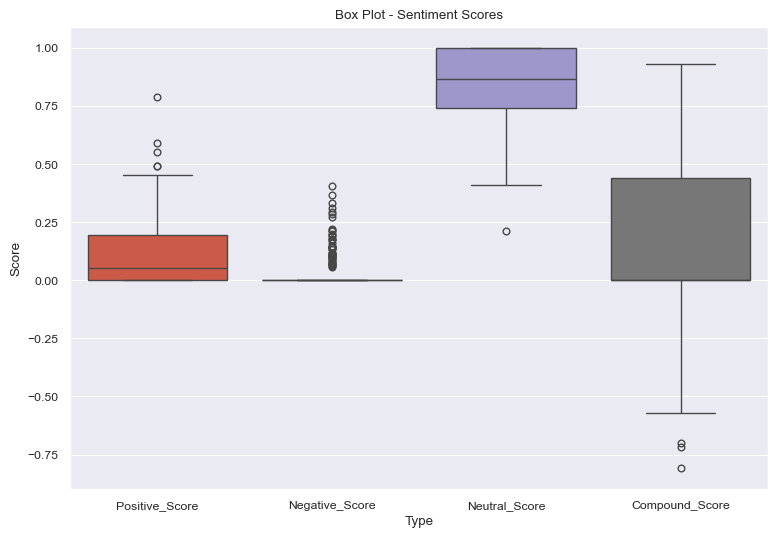

In [11]:
#| label: tweets-words-sentiment-scores-box-plot

plt.figure(figsize = (9, 6))
sns.boxplot(data = scores)

plt.title("Box Plot - Sentiment Scores")
plt.xlabel("Type")
plt.ylabel("Score")

plt.show()

It looks like the sentiment scores could be useful as an extra feature - but without access to historical tweets, 
it would be impossible to tell conclusively, but it could be worth investigating further.

## Conclusion

predicting NSEI open direction looks very promissing. We have shown the ability to train models with 
accuracy of around 75% in the case of SVM, and 76% in the case of PyTorch deep learning model - I am 
confident that with enhanced model tuning, and by adding extra features such as sentiment, we can 
improve accuracy significantly. 